# Telco Customer Churn - data mining and machine learning pipeline

## Import libraries

In [1]:
# IO
import os
import pathlib
from pathlib import Path

# Data processing
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised
import sklearn.metrics
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, pairwise_distances_argmin_min
    )
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Supervised
from sklearn.model_selection import train_test_split, GridSearchCV
## Models
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Association rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Define custom functions

### Data processing

Map categorical data to numerical

In [2]:
def map_categorical_to_num(df, one_hot=False):
    categorical_cols = [c for c in df.columns if (df[c].dtype == 'object' or df[c].dtype == 'category')] #select categorical columns
    attr_maps = {} #initialize dictionary
    for col in categorical_cols:
        if one_hot==True:
            if df[col].nunique() == 2:
                df[col], uniques = pd.factorize(df[col])
                attr_maps[col] = dict(zip(uniques, range(len(uniques)))) #fill dictionary
            else:
                df = pd.get_dummies(df, columns=[col])
        else:
            df[col], uniques = pd.factorize(df[col]) #pd.factorize encodes the object as an enumerated type or categorical variable
            attr_maps[col] = dict(zip(uniques, range(len(uniques)))) #fill dictionary
    return df, attr_maps

Binning numerical value

In [3]:
def map_numerical_to_categorical(df,column):
    df[column+'_bin'] = pd.qcut(df[column], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    df = df.drop([column],axis=1)
    return df

### Visualizations

Plot the KDE's of an attribute given the value of the binary target attribute. The attribute and the target must be strings and the target values should already be converted to 0,1

In [5]:
def kdeplot_binary_target(df,attribute,target):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(attribute))
    ax0 = sns.kdeplot(df[df[target] == 0][attribute].dropna(), color= 'navy', label= target+': No')
    ax1 = sns.kdeplot(df[df[target] == 1][attribute].dropna(), color= 'orange', label= target+': Yes')
    plt.legend()

We define a bar plot for categorical data which separates churn from no churn

In [6]:
def barplot_percentage_binary_target(df, attribute, target, label_dict, orient='v', axis_name="percentage of customers"):
    g = df.groupby(attribute)[target].value_counts().rename(axis_name).reset_index() #new data frame storing percentage
    g[axis_name] = g[axis_name]/len(df)

        
    # Reverse mapping for attribute and target
    reverse_attr_map = {v: k for k, v in label_dict.get(attribute, {}).items()}
    reverse_target_map = {v: k for k, v in label_dict.get(target, {}).items()}
    
    # Apply reverse mapping
    if reverse_attr_map:
        g[attribute] = g[attribute].map(reverse_attr_map)
    if reverse_target_map:
        g[target] = g[target].map(reverse_target_map)
    
    # Plot
    if orient == 'v':
        ax = sns.barplot(x=attribute, y=axis_name, hue=target, data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x=axis_name, y=attribute, hue=target, data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    
    plt.title(f"Distribution of {target} by {attribute}")
    plt.tight_layout()
    plt.show()

Now do the same thing for multiple columns

In [7]:
def multi_barplot_percentage(df, cols, target, label_dict, ncols=4):
    nrows = -(-len(cols) // ncols)  # Ceiling division
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        # Prepare data
        g = df.groupby(col)[target].value_counts().rename("Percentage").reset_index()
        g["Percentage"] = g["Percentage"] / len(df)

        # Reverse mapping
        attr_map = {v: k for k, v in label_dict.get(col, {}).items()}
        target_map = {v: k for k, v in label_dict.get(target, {}).items()}
        if attr_map:
            g[col] = g[col].map(attr_map)
        if target_map:
            g[target] = g[target].map(target_map)

        # Plot
        sns.barplot(x=col, y="Percentage", hue=target, data=g, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

#### Cluster evaluation

Function for estimating optimal clustering using knee method in various clustering methods

In [8]:
def cluster_parameter_estimation(X, method='kmeans', max_k=10, **kwargs):

    method = method.lower()
    valid_methods = ['kmeans', 'dbscan', 'agglomerative']
    if method not in valid_methods:
        raise ValueError(f"Invalid method '{method}'. Choose from {valid_methods}.")
    
    if method == 'kmeans':
        sse = []
        K_range = range(1, max_k + 1)
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', **kwargs)
            kmeans.fit(X)
            sse.append(kmeans.inertia_)

        # Plot elbow curve
        plt.figure(figsize=(8, 5))
        plt.plot(K_range, sse, marker='o')
        plt.title('Knee Method For Optimal k (KMeans)')
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Sum of Squared Errors (SSE)')
        plt.xticks(K_range)
        plt.grid(True)
        plt.show()

    elif method == 'dbscan':
        dist = pdist(X, 'euclidean')
        dist = squareform(dist) 
        k = 4
        kth_distances = list()
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.show()

    elif method == 'agglomerative':
        data_dist = pdist(X, metric='euclidean')
        data_link_single = linkage(data_dist, method='single', metric='euclidean')
        data_link_ward = linkage(data_dist, method='ward', metric='euclidean')
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        dendrogram(data_link_single, ax=ax1, truncate_mode='lastp')
        ax1.set_title("Dendrogram - Single Linkage")
        ax1.set_xlabel("Data Points")
        ax1.set_ylabel("Distance")

        dendrogram(data_link_ward, ax=ax2, truncate_mode='lastp')
        ax2.set_title("Dendrogram - Ward Linkage")
        ax2.set_xlabel("Data Points")
        ax2.set_ylabel("Distance")

        plt.tight_layout()
        plt.show()

#### ROC

Plot ROC's of multiple models on the same figure

In [9]:
def plot_combined_roc(models, labels):
    plt.figure(figsize=(10, 8))
    
    for model, label in zip(models, labels):
        fpr, tpr, roc_auc = model.get_roc_data()
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### Supervised learning models

In [10]:
def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics)
    print_result(logit.grid_search('roc_auc', grid), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    logit.plot_roc_curve()
    print("Best hyperparameters:", logit.hyperparameters)
    return logit

In [11]:
def svc_rbf(frame, grid):
    rbf = Model(SVC, frame, metrics, fixed_params= {'kernel': 'rbf', 'probability': True})
    print_result(rbf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rbf.train_and_evaluate_test(), "test set")
    rbf.plot_roc_curve()
    print("Best hyperparameters:", rbf.hyperparameters)
    return rbf

In [12]:
def random_forest(frame,grid):
    rf = Model(RandomForestClassifier, frame, metrics)
    print_result(rf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rf.train_and_evaluate_test(), "test set")
    rf.plot_roc_curve()
    print("Best hyperparameters:", rf.hyperparameters)
    return rf

In [13]:
def decision_tree(frame, grid):
    dt = Model(DecisionTreeClassifier, frame, metrics, fixed_params={})
    print_result(dt.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(dt.train_and_evaluate_test(), "test set")
    dt.plot_roc_curve()
    print("Best hyperparameters:", dt.hyperparameters)
    return dt

In [14]:
def print_result(results, sufix = ""):
    """ Function for printing the results nicely. """
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))
    print()

## Supervised learning model class

In [15]:
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=42, ):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # First divide data in learning set and final test set
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['customerID', 'Churn']]

    def grid_search(self, fit_metric, params, num_folds=10, num_repeats=3):
        print(self.fixed_params)
        stratified_cv = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=self.seed)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=stratified_cv, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['Churn'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
    
    def train_and_evaluate_test(self):
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_pred = clf.predict(self.test[self.predictors])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # For calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['Churn'], y_prob)))
            else:
                # For the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['Churn'], y_pred)))

        # Add confusion matrix
        cm = confusion_matrix(self.test['Churn'], y_pred)
        cm_df = pd.DataFrame(cm,
                            index=['Actual No', 'Actual Yes'],
                            columns=['Predicted No', 'Predicted Yes'])
        print("Confusion Matrix:\n", cm_df)
        print()
        
        return results

    def plot_roc_curve(self):
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        fpr, tpr, thresholds = roc_curve(self.test['Churn'], y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

    def get_roc_data(self):
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        fpr, tpr, _ = roc_curve(self.test['Churn'], y_prob)
        roc_auc = auc(fpr, tpr)
        return fpr, tpr, roc_auc

## Main

### Import data

Grab working folder and data folders in a OS-agnostic way.

In [4]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

In [5]:
telco_df = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Create data-frame copies for different purposes

We create copies of the original data-frame so that we can manipulate them according to specific purposes. E.G., for association rule mining, we will need a data frame whose column encode binary information --> we bin the numerical values and use one-hot encoding

Dataframe used for association rule mining

In [6]:
telco_df_ar = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

One-hot encoding for categorical attributes only

In [7]:
telco_df_oh = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

Modified version with binned tenure and where total charges are dropped and replaced with difference between them and (monthly charges)*(tenure)

In [8]:
telco_df_oh_tenurebin_nototal = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

Dataframe where we drop low importance features after a preliminary random forest run

In [9]:
telco_df_post = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

### Data exploration and preprocessing

#### Drop useless attributes

The customerID attribute has no statistical significance, so we can safely drop it

In [10]:
telco_df = telco_df.drop(['customerID'],axis=1)
telco_df_post = telco_df_post.drop(['customerID'],axis=1)
telco_df_ar = telco_df_ar.drop(['customerID'],axis=1)
telco_df_oh = telco_df_oh.drop(['customerID'],axis=1)
telco_df_oh_tenurebin_nototal = telco_df_oh_tenurebin_nototal.drop(['customerID'],axis=1)

Other useless attributes are analyzed later on the `telco_df` dataframe but will be dropped here for dataframes on which we plan to perform one hot encoding

In [11]:
telco_df_ar = telco_df_ar.drop('gender',axis=1)
telco_df_oh = telco_df_oh.drop('gender',axis=1)
telco_df_oh_tenurebin_nototal = telco_df_oh_tenurebin_nototal.drop('gender',axis=1)

#### Check for missing values

Looking at the output of .info(), there appears to be no missing value. However, the attribute TotalCharges being an object and not a float64 seems suspicious, maybe some of its values are not numeric.

In [25]:
non_numeric_mask = pd.to_numeric(telco_df['TotalCharges'], errors='coerce').isna()
telco_df[non_numeric_mask]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The non numeric values correspond to an empty space ' '. All these customers have 0 tenure, so we can conclude that we are dealing with customers who have not paid their bill yet. We can replace these values with 0

In [12]:
telco_df['TotalCharges'] = telco_df['TotalCharges'].replace(" ", 0).astype('float32')
# Drop missing values
telco_df.dropna(inplace=True)
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


Do the same for the other copies

In [13]:
telco_df_post['TotalCharges'] = telco_df_post['TotalCharges'].replace(" ", 0).astype('float32')
telco_df_ar['TotalCharges'] = telco_df_ar['TotalCharges'].replace(" ", 0).astype('float32')
telco_df_oh['TotalCharges'] = telco_df_oh['TotalCharges'].replace(" ", 0).astype('float32')
telco_df_oh_tenurebin_nototal['TotalCharges'] = telco_df_oh_tenurebin_nototal['TotalCharges'].replace(" ", 0).astype('float32')

#### Convert categorical data to numeric

First, we identify the categorical columns. Scanning over those, we replace the categorical values with numerical ones. We also save a dictionary keeping track of the conversion.

In [14]:
telco_df, category_dictionary = map_categorical_to_num(telco_df)
telco_df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.850000,0
1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.500000,0
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.150002,1
3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.750000,0
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.649994,1


In [230]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   int64  
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   int64  
 3   Dependents        7043 non-null   int64  
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   int64  
 6   MultipleLines     7043 non-null   int64  
 7   InternetService   7043 non-null   int64  
 8   OnlineSecurity    7043 non-null   int64  
 9   OnlineBackup      7043 non-null   int64  
 10  DeviceProtection  7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
 12  StreamingTV       7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  Contract          7043 non-null   int64  
 15  PaperlessBilling  7043 non-null   int64  
 16  PaymentMethod     7043 non-null   int64  


In [231]:
category_dictionary

{'gender': {'Female': 0, 'Male': 1},
 'Partner': {'Yes': 0, 'No': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'MultipleLines': {'No phone service': 0, 'No': 1, 'Yes': 2},
 'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'OnlineSecurity': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'OnlineBackup': {'Yes': 0, 'No': 1, 'No internet service': 2},
 'DeviceProtection': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'TechSupport': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'StreamingTV': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'StreamingMovies': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'PaperlessBilling': {'Yes': 0, 'No': 1},
 'PaymentMethod': {'Electronic check': 0,
  'Mailed check': 1,
  'Bank transfer (automatic)': 2,
  'Credit card (automatic)': 3},
 'Churn': {'No': 0, 'Yes': 1}}

We do the same for the `telco_df_post` dataframe

In [15]:
telco_df_post, _ = map_categorical_to_num(telco_df_post)

We will deal with the remaining dataframes differently: we perform a one hot encoding on all categorical attributes. This is usually done by running something like `df = pd.get_dummies(df, columns=[col])`, however, this creates a lot of redundancy particularly on attributes that already take on boolean values. In those cases, we will run `df[col], uniques = pd.factorize(df[col])`

In [16]:
telco_df_oh, _ = map_categorical_to_num(telco_df_oh, one_hot=True)

We do the same for `telco_df_oh_tenurebin_nototal`, but we first need to bin the tenure and before that we need to generate the ChargeDifference feature

In [17]:
telco_df_oh_tenurebin_nototal['ChargeDifference'] = telco_df_oh_tenurebin_nototal['TotalCharges'] - (telco_df_oh_tenurebin_nototal['tenure'] * telco_df_oh_tenurebin_nototal['MonthlyCharges'])
telco_df_oh_tenurebin_nototal = telco_df_oh_tenurebin_nototal.drop('TotalCharges',axis=1)

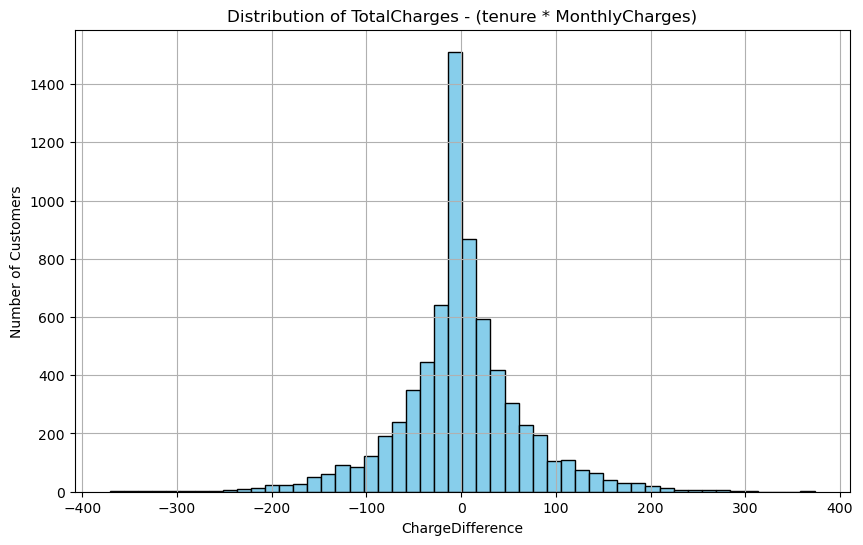

In [18]:
plt.figure(figsize=(10,6))
plt.hist(telco_df_oh_tenurebin_nototal['ChargeDifference'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of TotalCharges - (tenure * MonthlyCharges)')
plt.xlabel('ChargeDifference')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.show()

In [19]:
telco_df_oh_tenurebin_nototal = map_numerical_to_categorical(telco_df_oh_tenurebin_nototal, 'tenure')
telco_df_oh_tenurebin_nototal, _ = map_categorical_to_num(telco_df_oh_tenurebin_nototal, one_hot=True)

Similarly for `telco_df_ar`, we first need to bin all numerical features. Given that the difference
$$
TotalCharges - tenure*MonthlyCharges
$$
is usually within the range of a single Monthly charge, suggesting that the difference may be accounted for by early or missed payments, it's not that significant in terms of ranges of values --> we can drop the TotalCharges features for AR mining

In [20]:
telco_df_ar = telco_df_ar.drop('TotalCharges',axis=1)
telco_df_ar = map_numerical_to_categorical(telco_df_ar, 'tenure')
telco_df_ar = map_numerical_to_categorical(telco_df_ar, 'MonthlyCharges')
telco_df_ar, _ = map_categorical_to_num(telco_df_ar, one_hot=True)
telco_df_ar = pd.get_dummies(telco_df_ar, columns=['SeniorCitizen']) # This is an int feature so we need to address it directly given how our map_categorical_to_num function works

#### Normalize numerical data

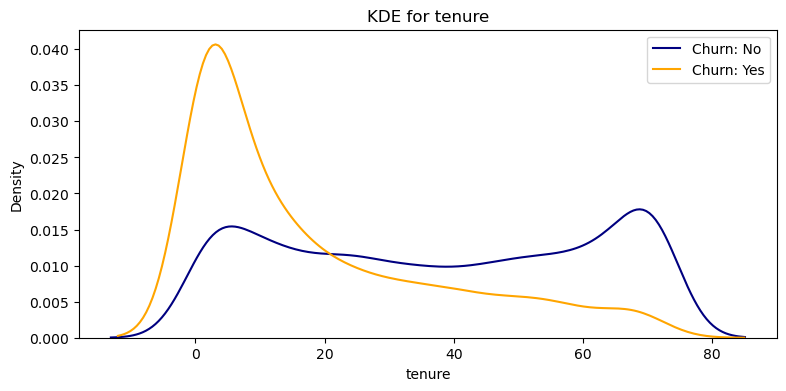

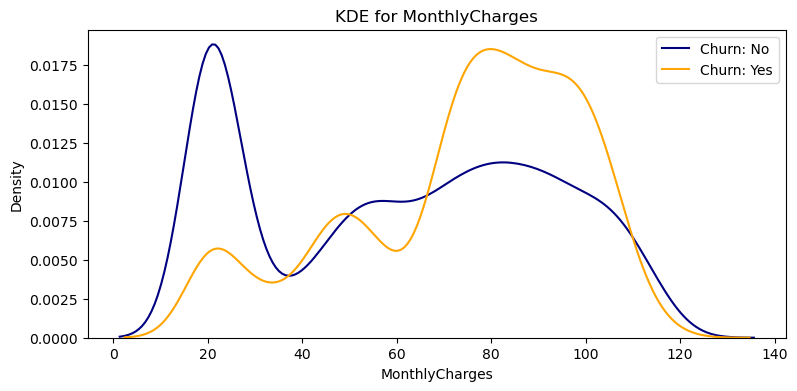

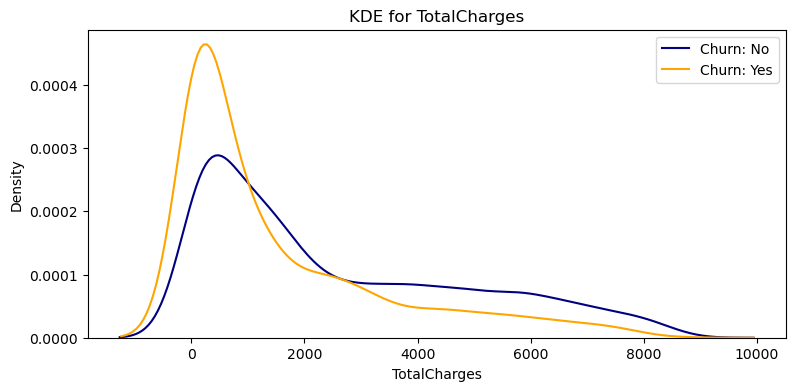

In [238]:
kdeplot_binary_target(telco_df,'tenure','Churn')
kdeplot_binary_target(telco_df,'MonthlyCharges','Churn')
kdeplot_binary_target(telco_df,'TotalCharges','Churn')

The ranges of these numerical data are wildly different. In order to build better models, we can normalize the data

In [239]:
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
telco_df[columns_to_scale] = StandardScaler().fit_transform(telco_df[columns_to_scale])
telco_df_post[columns_to_scale] = StandardScaler().fit_transform(telco_df_post[columns_to_scale])
telco_df_oh[columns_to_scale] = StandardScaler().fit_transform(telco_df_oh[columns_to_scale])
telco_df_oh_tenurebin_nototal['MonthlyCharges'] = StandardScaler().fit_transform(telco_df_oh_tenurebin_nototal[['MonthlyCharges']])
telco_df_oh_tenurebin_nototal['ChargeDifference'] = StandardScaler().fit_transform(telco_df_oh_tenurebin_nototal[['ChargeDifference']])

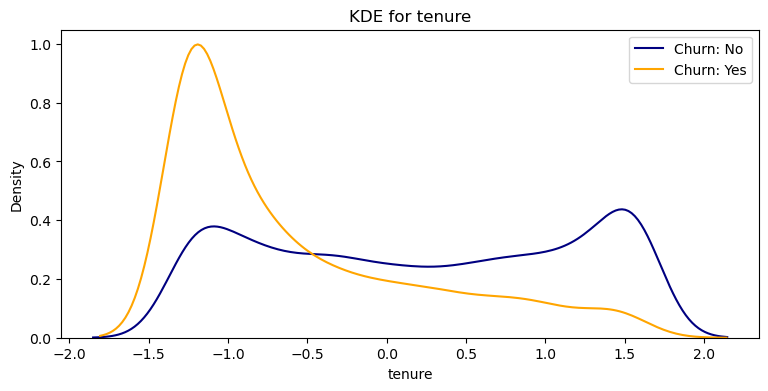

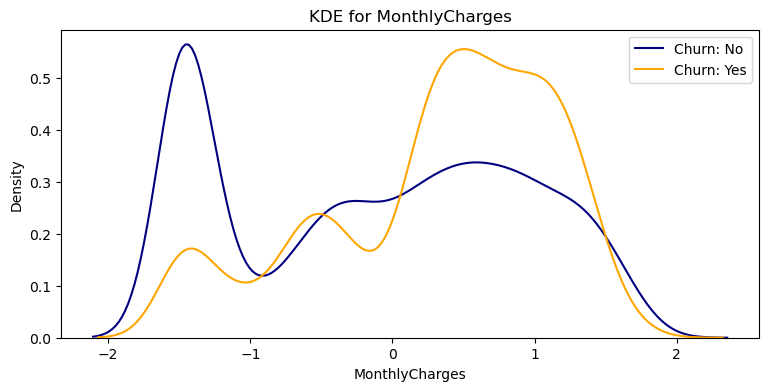

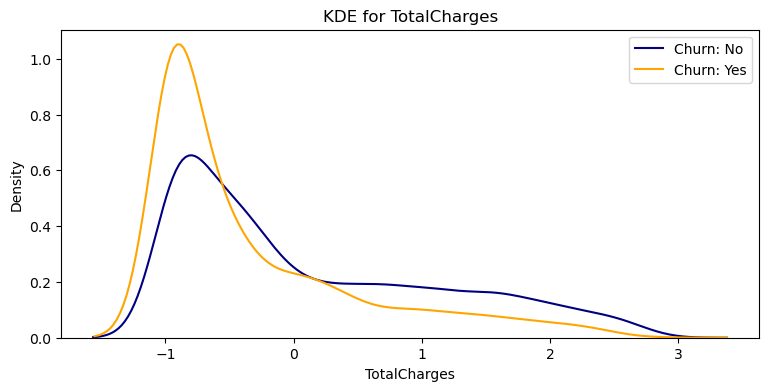

In [240]:
kdeplot_binary_target(telco_df,'tenure','Churn')
kdeplot_binary_target(telco_df,'MonthlyCharges','Churn')
kdeplot_binary_target(telco_df,'TotalCharges','Churn')

We can already see that these attributes have some predictive properties wrt the churn. Particularly for the tenure, we recognize that churn is much more likely in the range 0-20 (new customers are more likely to churn), in the range 20-40 there is no strong difference in churn probability, in the range 40-60 we start seeing more separation and in the range 60-(>80) churn is very unlikely relatively speaking (long-standing customers are less likely to churn). We could encode this information into a new variable which bins the tenure into 4 buckets, corresponding to the ranges described above

#### Explore distributions and correlations

##### Gender and age

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


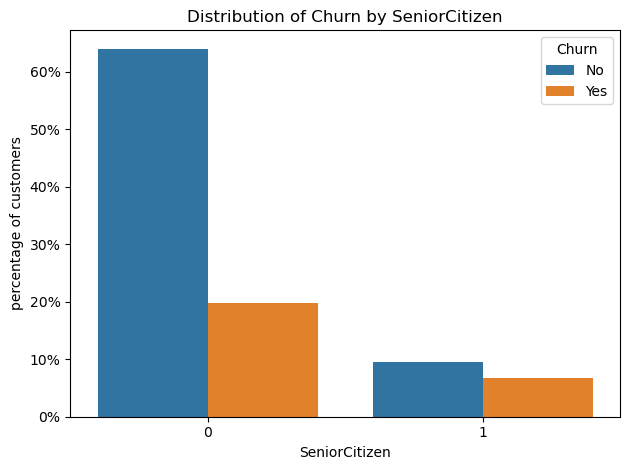

In [241]:
barplot_percentage_binary_target(telco_df,'SeniorCitizen','Churn', category_dictionary)

Senior citizens are relatively more likely to churn

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


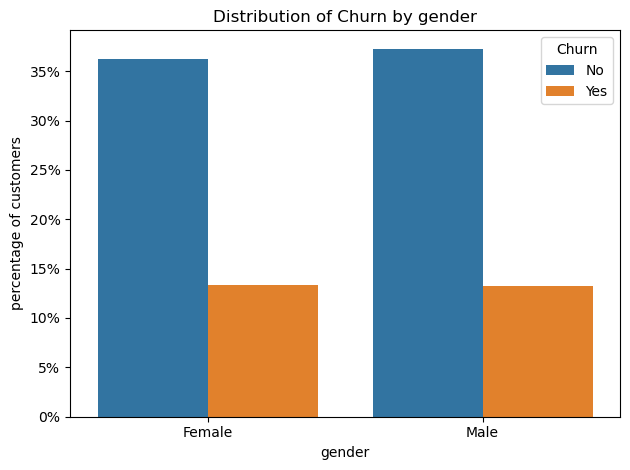

In [242]:
barplot_percentage_binary_target(telco_df,'gender','Churn', category_dictionary)

No discernable difference in churn rate based on gender, we drop the feature

In [243]:
telco_df = telco_df.drop('gender',axis=1)

##### Partners and dependents

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


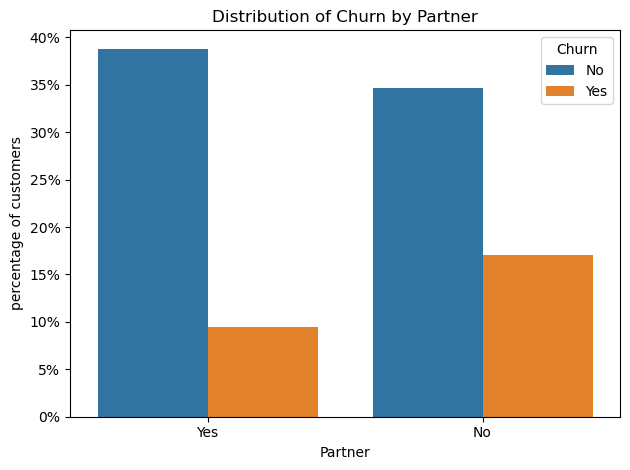

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


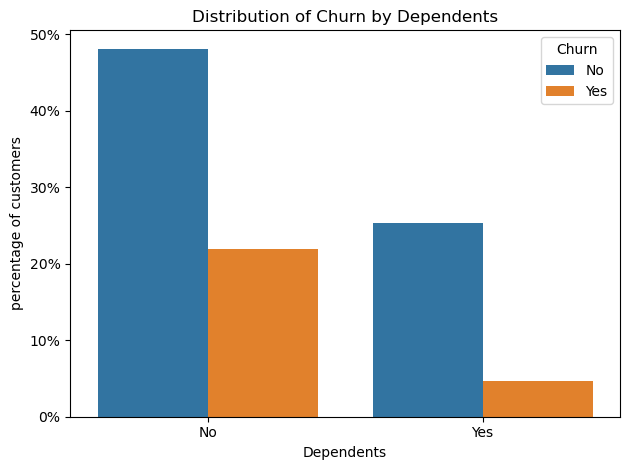

In [244]:
barplot_percentage_binary_target(telco_df,'Partner','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'Dependents','Churn', category_dictionary)

Customers with partners or dependents are less likely to churn

##### Services

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


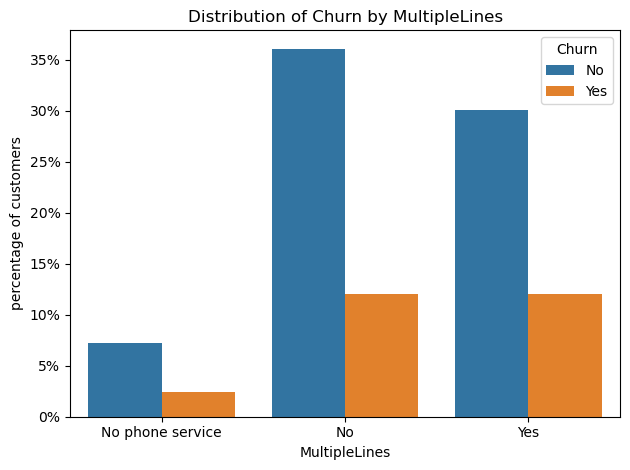

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


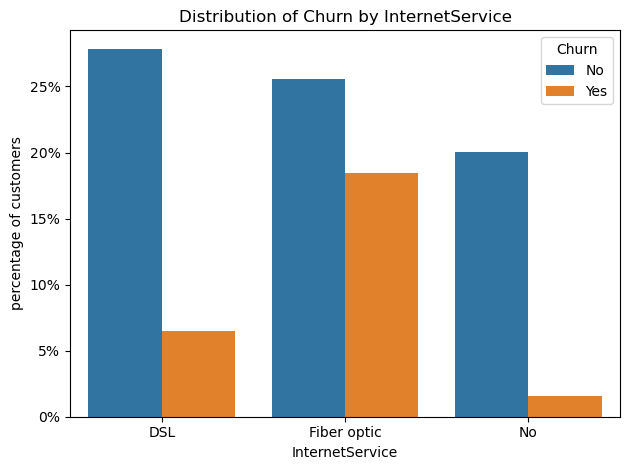

In [245]:
barplot_percentage_binary_target(telco_df,'MultipleLines','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'InternetService','Churn', category_dictionary)

Customers with multiple active lines are slightly more likely to churn (they may be more interested in finding better deals)
Customers with faster internet are more likely to churn (may be due to them being more tech savvy and able to find better deals)

/tmp/ipykernel_26222/2350287135.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_26222/2350287135.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_26222/2350287135.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_26222/2350287135.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_2

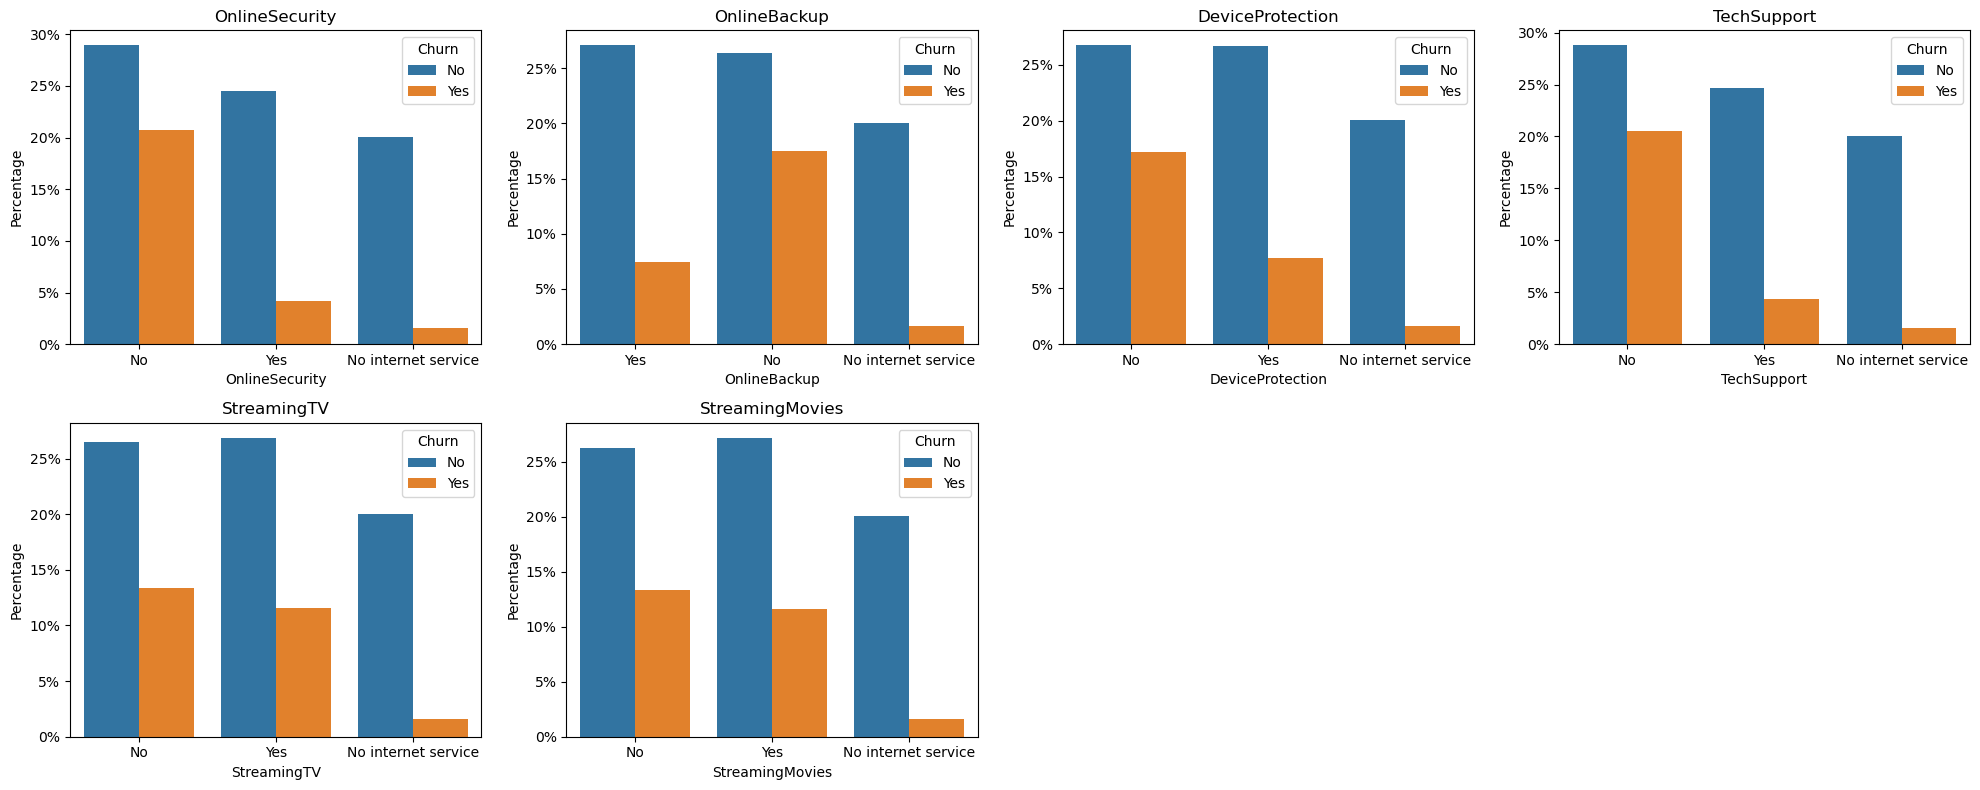

In [246]:
additional_services_columns = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
multi_barplot_percentage(telco_df,additional_services_columns,'Churn', category_dictionary)

##### Type of contract

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


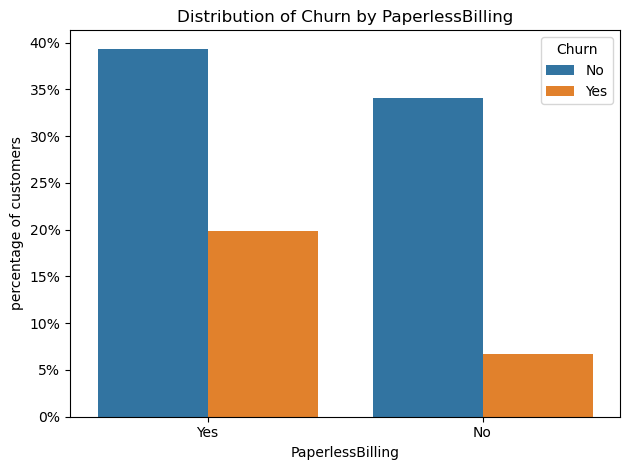

/tmp/ipykernel_26222/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


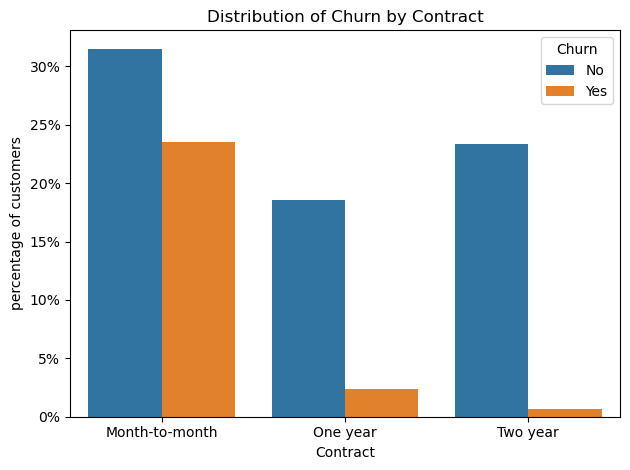

/tmp/ipykernel_26222/3242246602.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


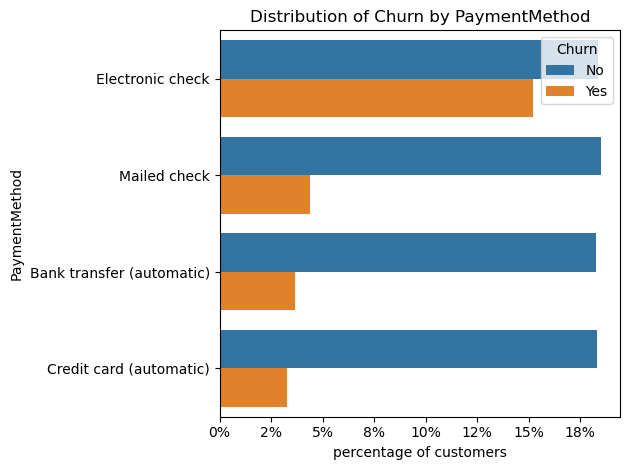

In [247]:
barplot_percentage_binary_target(telco_df,'PaperlessBilling','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'Contract','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'PaymentMethod','Churn', category_dictionary, orient='h')

##### Correlations

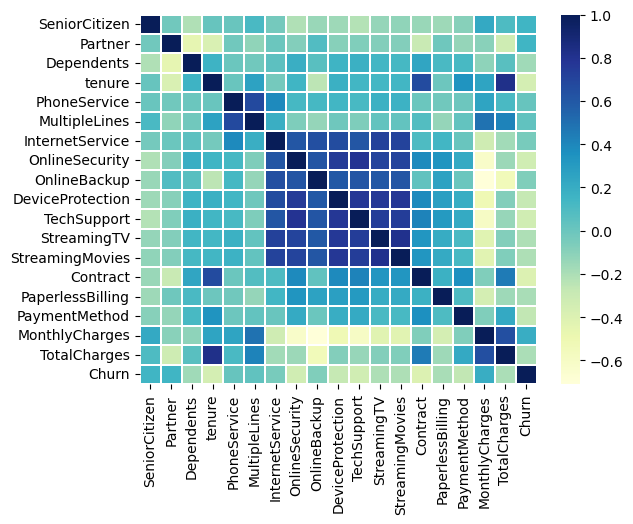

In [248]:
corr = telco_df.corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

##### Feature importance

Preliminary run of a supervised learning algorithm to give us an idea of what features actually matter when determining churn. We will only keep the top 10 features in `telco_df_post`

/tmp/ipykernel_26222/325296606.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')


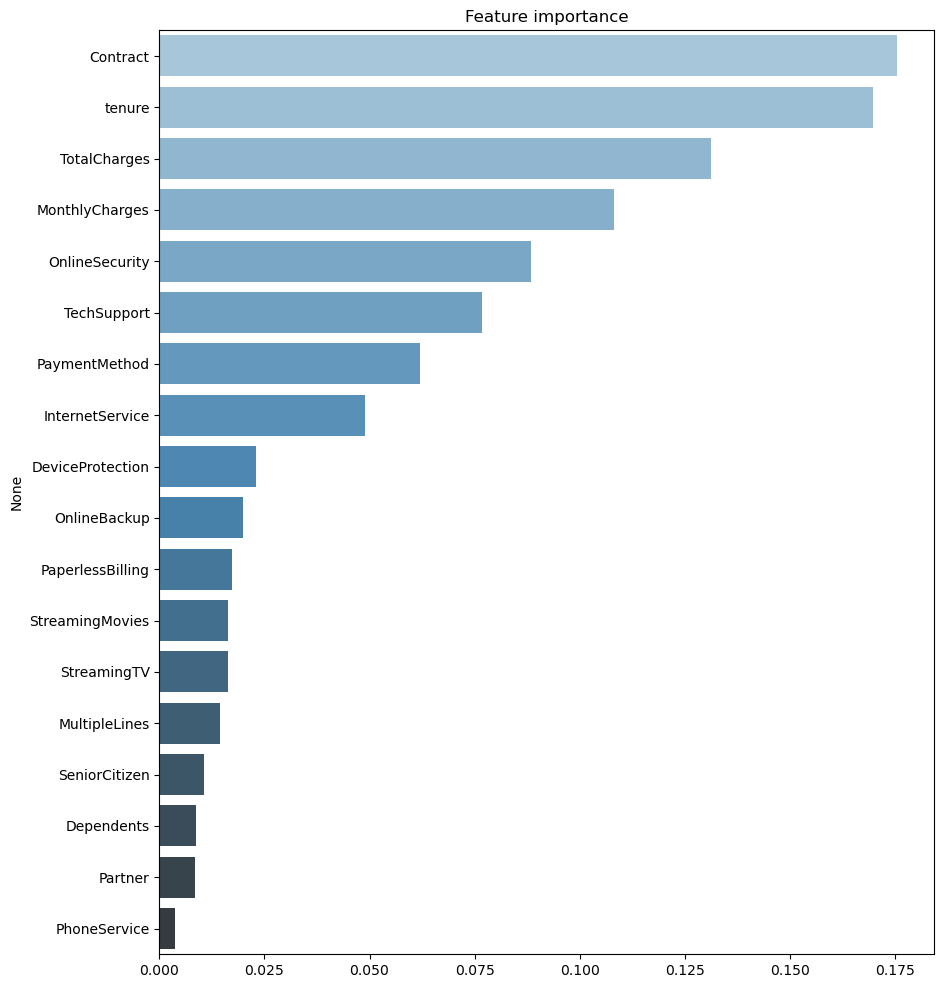

In [249]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
x, y = telco_df.drop('Churn',axis=1), telco_df['Churn']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

In [250]:
dropped_columns = ['PhoneService','Partner','Dependents','SeniorCitizen','MultipleLines','StreamingTV','PaperlessBilling','StreamingMovies']
telco_df_post = telco_df_post.drop(dropped_columns,axis=1)

### Unsupervised learning

Drop Churn target for unsupervised learning

In [251]:
X = telco_df.drop('Churn',axis=1)
X_post = telco_df_post.drop('Churn',axis=1)
X_oh = telco_df_oh.astype({col: 'int' for col in telco_df_oh.select_dtypes('bool').columns}).drop('Churn',axis=1)
X_oh2 = telco_df_oh_tenurebin_nototal.astype({col: 'int' for col in telco_df_oh_tenurebin_nototal.select_dtypes('bool').columns}).drop('Churn',axis=1)
true_labels = np.asarray(telco_df['Churn'])

#### Hierarchical clustering

Plot the dendrogram

We will use two methods: Ward and Min, whose strenghts and weaknesses balance out (Ward is less sensitive to noise but biased towards globular shapes, while Min can handle non elliptical shapes but is sensitive to noise)

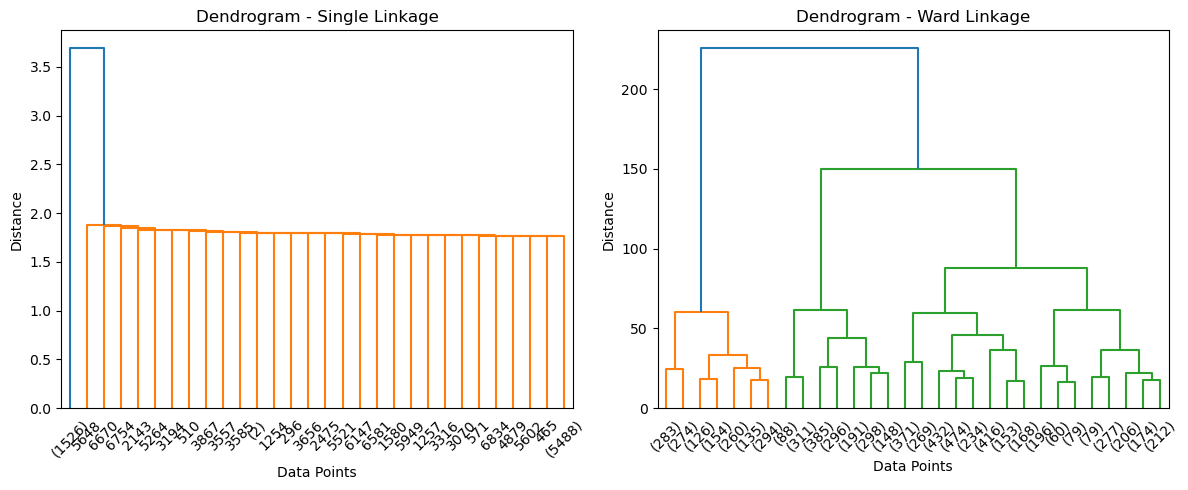

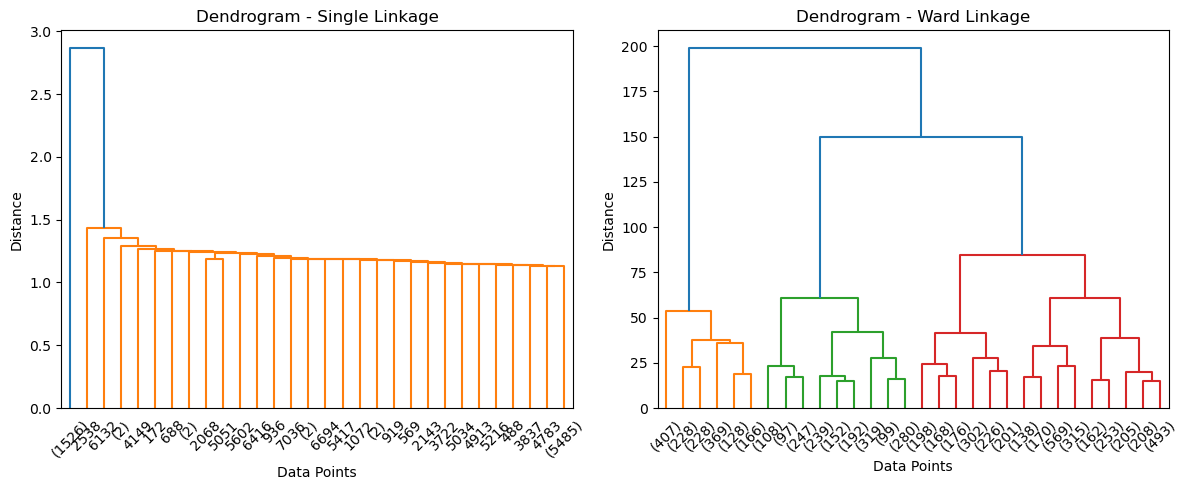

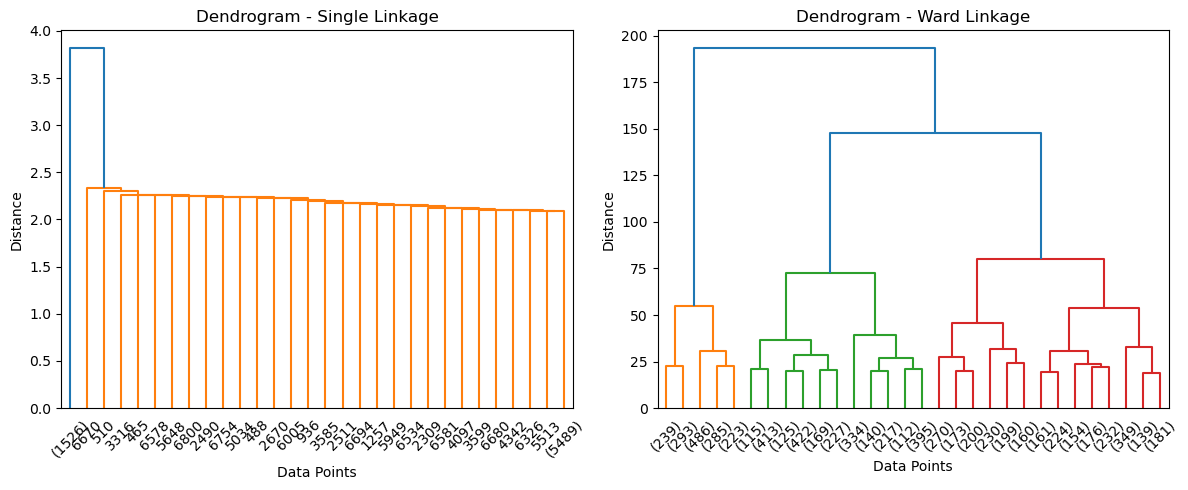

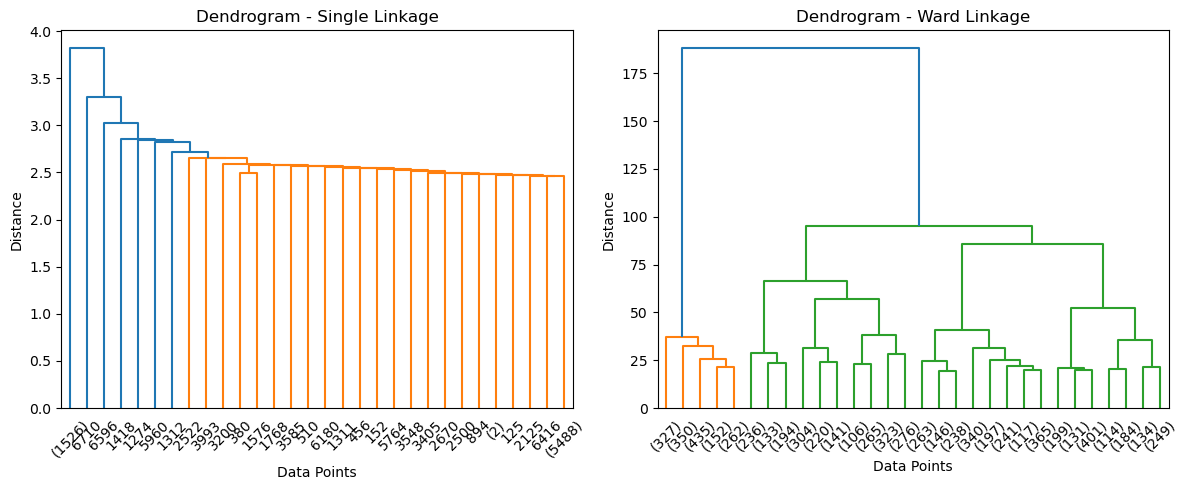

In [294]:
cluster_parameter_estimation(X,method='agglomerative')
cluster_parameter_estimation(X_post,method='agglomerative')
cluster_parameter_estimation(X_oh,method='agglomerative')
cluster_parameter_estimation(X_oh2,method='agglomerative')

It looks like there are ~3 natural clusters, we can confirm that using a knee method based on an internal measure (SSE) for kmeans

##### External evaluation

In [253]:
hie = AgglomerativeClustering(n_clusters=3, linkage='ward')
hie_post = AgglomerativeClustering(n_clusters=3, linkage='ward')
hie_oh = AgglomerativeClustering(n_clusters=3, linkage='ward')
hie_oh2 = AgglomerativeClustering(n_clusters=3, linkage='ward')

In [254]:
hie_labels = hie.fit_predict(X)
hie_labels_post = hie.fit_predict(X_post)
hie_labels_oh = hie.fit_predict(X_oh)
hie_labels_oh2 = hie.fit_predict(X_oh2)

External scores for 3 clusters and ward linkage

In [255]:
ari3 = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels)
hom3 = sklearn.metrics.homogeneity_score(true_labels, hie_labels)
compl3 = sklearn.metrics.completeness_score(true_labels, hie_labels)
vmeas3 = sklearn.metrics.v_measure_score(true_labels, hie_labels, beta=2) 

ari3_post = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_post)
hom3_post = sklearn.metrics.homogeneity_score(true_labels, hie_labels_post)
compl3_post = sklearn.metrics.completeness_score(true_labels, hie_labels_post)
vmeas3_post = sklearn.metrics.v_measure_score(true_labels, hie_labels_post, beta=2) 

ari3_oh = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_oh)
hom3_oh = sklearn.metrics.homogeneity_score(true_labels, hie_labels_oh)
compl3_oh = sklearn.metrics.completeness_score(true_labels, hie_labels_oh)
vmeas3_oh = sklearn.metrics.v_measure_score(true_labels, hie_labels_oh, beta=2) 

ari3_oh2 = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_oh2)
hom3_oh2 = sklearn.metrics.homogeneity_score(true_labels, hie_labels_oh2)
compl3_oh2 = sklearn.metrics.completeness_score(true_labels, hie_labels_oh2)
vmeas3_oh2 = sklearn.metrics.v_measure_score(true_labels, hie_labels_oh2, beta=2) 

print(f"ARI for 3 clusters: {ari3:.4f}")
print(f"Homogeneity for 3 clusters: {hom3:.4f}")
print(f"Completeness for 3 clusters: {compl3:.4f}")
print(f"V Measure for 3 clusters: {vmeas3:.4f}")
print()
print(f"ARI for 3 clusters, post: {ari3_post:.4f}")
print(f"Homogeneity for 3 clusters, post: {hom3_post:.4f}")
print(f"Completeness for 3 clusters, post: {compl3_post:.4f}")
print(f"V Measure for 3 clusters, post: {vmeas3_post:.4f}")
print()
print(f"ARI for 3 clusters, oh: {ari3_oh:.4f}")
print(f"Homogeneity for 3 clusters, oh: {hom3_oh:.4f}")
print(f"Completeness for 3 clusters, oh: {compl3_oh:.4f}")
print(f"V Measure for 3 clusters, oh: {vmeas3_oh:.4f}")
print()
print(f"ARI for 3 clusters, oh2: {ari3_oh2:.4f}")
print(f"Homogeneity for 3 clusters, oh2: {hom3_oh2:.4f}")
print(f"Completeness for 3 clusters, oh2: {compl3_oh2:.4f}")
print(f"V Measure for 3 clusters, oh2: {vmeas3_oh2:.4f}")

ARI for 3 clusters: -0.0176
Homogeneity for 3 clusters: 0.1169
Completeness for 3 clusters: 0.0671
V Measure for 3 clusters: 0.0782

ARI for 3 clusters, post: -0.0137
Homogeneity for 3 clusters, post: 0.1287
Completeness for 3 clusters, post: 0.0737
V Measure for 3 clusters, post: 0.0860

ARI for 3 clusters, oh: 0.0557
Homogeneity for 3 clusters, oh: 0.1346
Completeness for 3 clusters, oh: 0.0731
V Measure for 3 clusters, oh: 0.0862

ARI for 3 clusters, oh2: 0.0165
Homogeneity for 3 clusters, oh2: 0.1302
Completeness for 3 clusters, oh2: 0.0718
V Measure for 3 clusters, oh2: 0.0844


Repeat for min linkage

In [256]:
hie = AgglomerativeClustering(n_clusters=3, linkage='single')
hie_post = AgglomerativeClustering(n_clusters=3, linkage='single')
hie_oh = AgglomerativeClustering(n_clusters=3, linkage='single')
hie_oh2 = AgglomerativeClustering(n_clusters=3, linkage='single')

In [257]:
hie_labels = hie.fit_predict(X)
hie_labels_post = hie.fit_predict(X_post)
hie_labels_oh = hie.fit_predict(X_oh)
hie_labels_oh2 = hie.fit_predict(X_oh2)

In [258]:
ari3 = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels)
hom3 = sklearn.metrics.homogeneity_score(true_labels, hie_labels)
compl3 = sklearn.metrics.completeness_score(true_labels, hie_labels)
vmeas3 = sklearn.metrics.v_measure_score(true_labels, hie_labels, beta=2) 

ari3_post = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_post)
hom3_post = sklearn.metrics.homogeneity_score(true_labels, hie_labels_post)
compl3_post = sklearn.metrics.completeness_score(true_labels, hie_labels_post)
vmeas3_post = sklearn.metrics.v_measure_score(true_labels, hie_labels_post, beta=2) 

ari3_oh = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_oh)
hom3_oh = sklearn.metrics.homogeneity_score(true_labels, hie_labels_oh)
compl3_oh = sklearn.metrics.completeness_score(true_labels, hie_labels_oh)
vmeas3_oh = sklearn.metrics.v_measure_score(true_labels, hie_labels_oh, beta=2) 

ari3_oh2 = sklearn.metrics.adjusted_rand_score(true_labels, hie_labels_oh2)
hom3_oh2 = sklearn.metrics.homogeneity_score(true_labels, hie_labels_oh2)
compl3_oh2 = sklearn.metrics.completeness_score(true_labels, hie_labels_oh2)
vmeas3_oh2 = sklearn.metrics.v_measure_score(true_labels, hie_labels_oh2, beta=2) 

print(f"ARI for 3 clusters: {ari3:.4f}")
print(f"Homogeneity for 3 clusters: {hom3:.4f}")
print(f"Completeness for 3 clusters: {compl3:.4f}")
print(f"V Measure for 3 clusters: {vmeas3:.4f}")
print()
print(f"ARI for 3 clusters, post: {ari3_post:.4f}")
print(f"Homogeneity for 3 clusters, post: {hom3_post:.4f}")
print(f"Completeness for 3 clusters, post: {compl3_post:.4f}")
print(f"V Measure for 3 clusters, post: {vmeas3_post:.4f}")
print()
print(f"ARI for 3 clusters, oh: {ari3_oh:.4f}")
print(f"Homogeneity for 3 clusters, oh: {hom3_oh:.4f}")
print(f"Completeness for 3 clusters, oh: {compl3_oh:.4f}")
print(f"V Measure for 3 clusters, oh: {vmeas3_oh:.4f}")
print()
print(f"ARI for 3 clusters, oh2: {ari3_oh2:.4f}")
print(f"Homogeneity for 3 clusters, oh2: {hom3_oh2:.4f}")
print(f"Completeness for 3 clusters, oh2: {compl3_oh2:.4f}")
print(f"V Measure for 3 clusters, oh2: {vmeas3_oh2:.4f}")

ARI for 3 clusters: -0.0655
Homogeneity for 3 clusters: 0.0543
Completeness for 3 clusters: 0.0600
V Measure for 3 clusters: 0.0580

ARI for 3 clusters, post: -0.0655
Homogeneity for 3 clusters, post: 0.0543
Completeness for 3 clusters, post: 0.0600
V Measure for 3 clusters, post: 0.0580

ARI for 3 clusters, oh: -0.0655
Homogeneity for 3 clusters, oh: 0.0543
Completeness for 3 clusters, oh: 0.0600
V Measure for 3 clusters, oh: 0.0580

ARI for 3 clusters, oh2: -0.0655
Homogeneity for 3 clusters, oh2: 0.0543
Completeness for 3 clusters, oh2: 0.0600
V Measure for 3 clusters, oh2: 0.0580


#### K-means

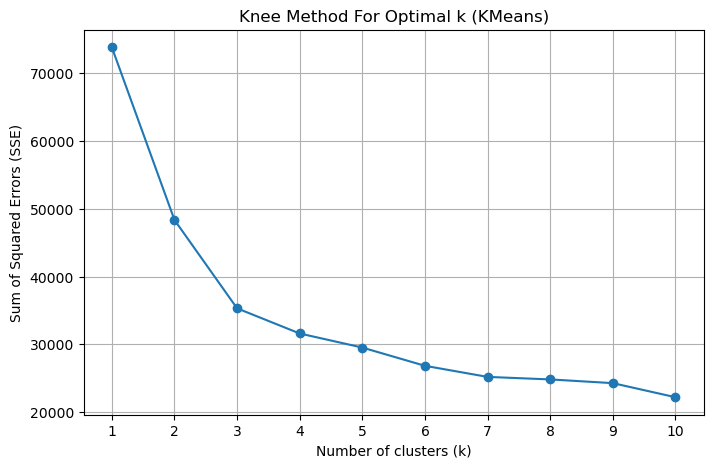

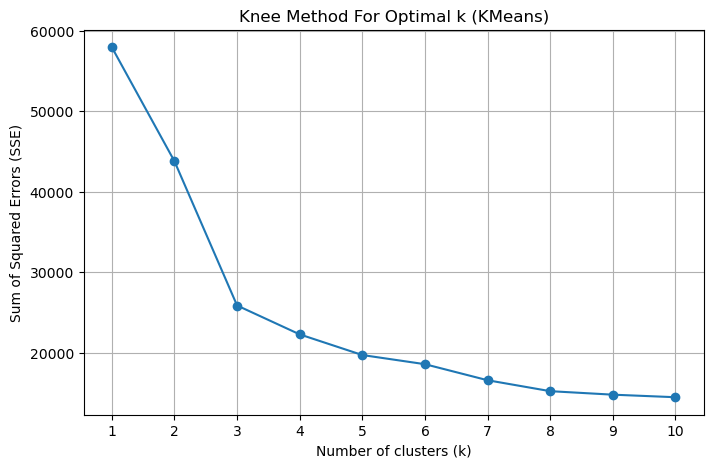

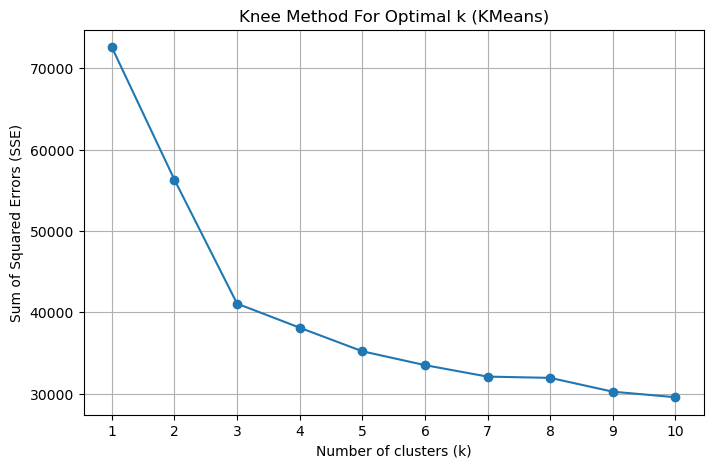

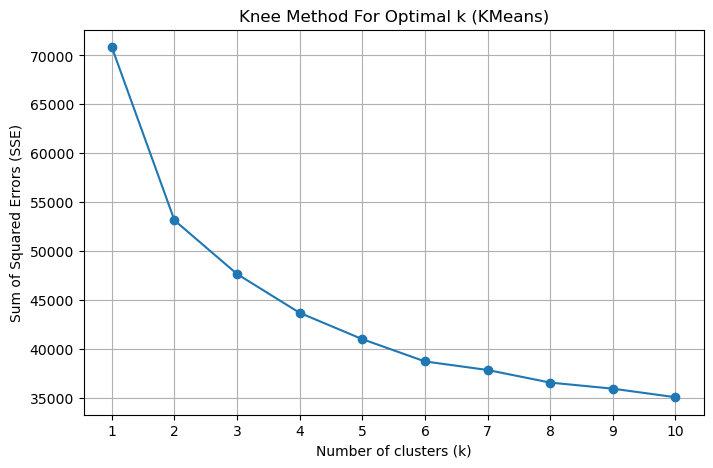

In [259]:
cluster_parameter_estimation(X,method='kmeans')
cluster_parameter_estimation(X_post,method='kmeans')
cluster_parameter_estimation(X_oh,method='kmeans')
cluster_parameter_estimation(X_oh2,method='kmeans')

The knee method confirms what we saw for hierarchical clustering

##### Internal evaluation

We evaluate the performance of the kmeans clustering using 3 and 4 clusters

In [260]:
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3.fit(X)
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_4.fit(X)

kmeans_3_post = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3_post.fit(X_post)
kmeans_4_post = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_4_post.fit(X_post)

kmeans_3_oh = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3_oh.fit(X_oh)
kmeans_4_oh = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_4_oh.fit(X_oh)

kmeans_3_oh2 = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3_oh2.fit(X_oh2)
kmeans_4_oh2 = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans_4_oh2.fit(X_oh2)

KMeans(n_clusters=4, random_state=42)

We will use the Silhouette and Separation metrics

Silhouette ranges from -1 to 1. -1: probably wrong cluster. 0: cluster overlap. 1: cluster is dense and well separated.

Clusters which are farther apart and less dispersed will result in a better separation score, closer to 0.

Results for `telco_df` dataframe

In [261]:
print('SSE %s' % kmeans_3.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_3.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_3.labels_))

SSE 35312.82005109655
Silhouette 0.32982361742458327
Separation 1.2643144027042155


In [262]:
print('SSE %s' % kmeans_4.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_4.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_4.labels_))

SSE 31603.81338886185
Silhouette 0.2760989868356988
Separation 1.543900268519548


Results for `telco_df_post` dataframe

In [263]:
print('SSE %s' % kmeans_3_post.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_3_post.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_3_post.labels_))

SSE 25848.766185082055
Silhouette 0.32872731243955483
Separation 1.271471478617309


In [264]:
print('SSE %s' % kmeans_4_post.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_4_post.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_4_post.labels_))

SSE 22257.7516738293
Silhouette 0.2755355380190897
Separation 1.5018155082170364


Results for `telco_df_oh` dataframe

In [265]:
print('SSE %s' % kmeans_3_oh.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_3_oh.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_3_oh.labels_))

SSE 41070.33421674584
Silhouette 0.32157135277363075
Separation 1.2962429323950524


In [266]:
print('SSE %s' % kmeans_4_oh.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_4_oh.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_4_oh.labels_))

SSE 38111.1201297994
Silhouette 0.2662425441722847
Separation 1.6846153689482033


Results for `telco_df_oh_tenurebin_nototal` dataframe

In [267]:
print('SSE %s' % kmeans_3_oh2.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_3_oh2.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_3_oh2.labels_))

SSE 47663.0277159878
Silhouette 0.20766393587589885
Separation 2.1921513878554815


In [268]:
print('SSE %s' % kmeans_4_oh2.inertia_)
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, kmeans_4_oh2.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, kmeans_4_oh2.labels_))

SSE 43694.153177614724
Silhouette 0.22776321328976273
Separation 1.8505819640713197


##### External evaluation

In [269]:
np.unique(true_labels, return_counts=True)

(array([0, 1]), array([5174, 1869]))

In [270]:
print(np.unique(kmeans_3.labels_, return_counts=True))
print(np.unique(kmeans_3_post.labels_, return_counts=True))
print(np.unique(kmeans_3_oh.labels_, return_counts=True))
print(np.unique(kmeans_3_oh2.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([3302, 2215, 1526]))
(array([0, 1, 2], dtype=int32), array([2237, 3280, 1526]))
(array([0, 1, 2], dtype=int32), array([1526, 3192, 2325]))
(array([0, 1, 2], dtype=int32), array([2407, 3110, 1526]))


In [271]:
print(np.unique(kmeans_4.labels_, return_counts=True))
print(np.unique(kmeans_4_post.labels_, return_counts=True))
print(np.unique(kmeans_4_oh.labels_, return_counts=True))
print(np.unique(kmeans_4_oh2.labels_, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([1354, 1798, 1526, 2365]))
(array([0, 1, 2, 3], dtype=int32), array([1196, 1836, 1526, 2485]))
(array([0, 1, 2, 3], dtype=int32), array([1205, 2654, 1658, 1526]))
(array([0, 1, 2, 3], dtype=int32), array([1379, 1928, 1526, 2210]))


We will use the ARI, homogeneity score, completeness score and the harmonic mean of the last 2

An ARI score of 0 indicates that cluster labels are randomly assigned, and an ARI score of 1 means that the true labels and predicted labels form identical clusters.

The homogeneity score gives us some information on whether clusters have objects with the same real labels

The completeness score tells us whether real labels are concentrated in specific clusters

In [272]:
ari3 = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_3.labels_)
hom3 = sklearn.metrics.homogeneity_score(true_labels, kmeans_3.labels_)
compl3 = sklearn.metrics.completeness_score(true_labels, kmeans_3.labels_)
vmeas3 = sklearn.metrics.v_measure_score(true_labels, kmeans_3.labels_, beta=2) 

ari3_post = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_3_post.labels_)
hom3_post = sklearn.metrics.homogeneity_score(true_labels, kmeans_3_post.labels_)
compl3_post = sklearn.metrics.completeness_score(true_labels, kmeans_3_post.labels_)
vmeas3_post = sklearn.metrics.v_measure_score(true_labels, kmeans_3_post.labels_, beta=2) 

ari3_oh = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_3_oh.labels_)
hom3_oh = sklearn.metrics.homogeneity_score(true_labels, kmeans_3_oh.labels_)
compl3_oh = sklearn.metrics.completeness_score(true_labels, kmeans_3_oh.labels_)
vmeas3_oh = sklearn.metrics.v_measure_score(true_labels, kmeans_3_oh.labels_, beta=2) 

ari3_oh2 = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_3_oh2.labels_)
hom3_oh2 = sklearn.metrics.homogeneity_score(true_labels, kmeans_3_oh2.labels_)
compl3_oh2 = sklearn.metrics.completeness_score(true_labels, kmeans_3_oh2.labels_)
vmeas3_oh2 = sklearn.metrics.v_measure_score(true_labels, kmeans_3_oh2.labels_, beta=2) 

print(f"ARI for 3 clusters: {ari3:.4f}")
print(f"Homogeneity for 3 clusters: {hom3:.4f}")
print(f"Completeness for 3 clusters: {compl3:.4f}")
print(f"V Measure for 3 clusters: {vmeas3:.4f}")
print()
print(f"ARI for 3 clusters, post: {ari3_post:.4f}")
print(f"Homogeneity for 3 clusters, post: {hom3_post:.4f}")
print(f"Completeness for 3 clusters, post: {compl3_post:.4f}")
print(f"V Measure for 3 clusters, post: {vmeas3_post:.4f}")
print()
print(f"ARI for 3 clusters, oh: {ari3_oh:.4f}")
print(f"Homogeneity for 3 clusters, oh: {hom3_oh:.4f}")
print(f"Completeness for 3 clusters, oh: {compl3_oh:.4f}")
print(f"V Measure for 3 clusters, oh: {vmeas3_oh:.4f}")
print()
print(f"ARI for 3 clusters, oh2: {ari3_oh2:.4f}")
print(f"Homogeneity for 3 clusters, oh2: {hom3_oh2:.4f}")
print(f"Completeness for 3 clusters, oh2: {compl3_oh2:.4f}")
print(f"V Measure for 3 clusters, oh2: {vmeas3_oh2:.4f}")

ARI for 3 clusters: 0.0169
Homogeneity for 3 clusters: 0.1288
Completeness for 3 clusters: 0.0710
V Measure for 3 clusters: 0.0834

ARI for 3 clusters, post: 0.0235
Homogeneity for 3 clusters, post: 0.1398
Completeness for 3 clusters, post: 0.0769
V Measure for 3 clusters, post: 0.0905

ARI for 3 clusters, oh: 0.0201
Homogeneity for 3 clusters, oh: 0.1224
Completeness for 3 clusters, oh: 0.0671
V Measure for 3 clusters, oh: 0.0790

ARI for 3 clusters, oh2: 0.0098
Homogeneity for 3 clusters, oh2: 0.0955
Completeness for 3 clusters, oh2: 0.0521
V Measure for 3 clusters, oh2: 0.0614


In [273]:
ari4 = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_4.labels_)
hom4 = sklearn.metrics.homogeneity_score(true_labels, kmeans_4.labels_)
compl4 = sklearn.metrics.completeness_score(true_labels, kmeans_4.labels_)
vmeas4 = sklearn.metrics.v_measure_score(true_labels, kmeans_4.labels_, beta=2) 

ari4_post = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_4_post.labels_)
hom4_post = sklearn.metrics.homogeneity_score(true_labels, kmeans_4_post.labels_)
compl4_post = sklearn.metrics.completeness_score(true_labels, kmeans_4_post.labels_)
vmeas4_post = sklearn.metrics.v_measure_score(true_labels, kmeans_4_post.labels_, beta=2) 

ari4_oh = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_4_oh.labels_)
hom4_oh = sklearn.metrics.homogeneity_score(true_labels, kmeans_4_oh.labels_)
compl4_oh = sklearn.metrics.completeness_score(true_labels, kmeans_4_oh.labels_)
vmeas4_oh = sklearn.metrics.v_measure_score(true_labels, kmeans_4_oh.labels_, beta=2) 

ari4_oh2 = sklearn.metrics.adjusted_rand_score(true_labels, kmeans_4_oh2.labels_)
hom4_oh2 = sklearn.metrics.homogeneity_score(true_labels, kmeans_4_oh2.labels_)
compl4_oh2 = sklearn.metrics.completeness_score(true_labels, kmeans_4_oh2.labels_)
vmeas4_oh2 = sklearn.metrics.v_measure_score(true_labels, kmeans_4_oh2.labels_, beta=2) 

print(f"ARI for 4 clusters: {ari4:.4f}")
print(f"Homogeneity for 4 clusters: {hom4:.4f}")
print(f"Completeness for 4 clusters: {compl4:.4f}")
print(f"V Measure for 4 clusters: {vmeas4:.4f}")
print()
print(f"ARI for 4 clusters, post: {ari4_post:.4f}")
print(f"Homogeneity for 4 clusters, post: {hom4_post:.4f}")
print(f"Completeness for 4 clusters, post: {compl4_post:.4f}")
print(f"V Measure for 4 clusters, post: {vmeas4_post:.4f}")
print()
print(f"ARI for 4 clusters, oh: {ari4_oh:.4f}")
print(f"Homogeneity for 4 clusters, oh: {hom4_oh:.4f}")
print(f"Completeness for 4 clusters, oh: {compl4_oh:.4f}")
print(f"V Measure for 4 clusters, oh: {vmeas4_oh:.4f}")
print()
print(f"ARI for 4 clusters, oh2: {ari4_oh2:.4f}")
print(f"Homogeneity for 4 clusters, oh2: {hom4_oh2:.4f}")
print(f"Completeness for 4 clusters, oh2: {compl4_oh2:.4f}")
print(f"V Measure for 4 clusters, oh2: {vmeas4_oh2:.4f}")

ARI for 4 clusters: 0.0387
Homogeneity for 4 clusters: 0.1416
Completeness for 4 clusters: 0.0601
V Measure for 4 clusters: 0.0744

ARI for 4 clusters, post: 0.0373
Homogeneity for 4 clusters, post: 0.1413
Completeness for 4 clusters, post: 0.0605
V Measure for 4 clusters, post: 0.0748

ARI for 4 clusters, oh: 0.0296
Homogeneity for 4 clusters, oh: 0.1722
Completeness for 4 clusters, oh: 0.0743
V Measure for 4 clusters, oh: 0.0916

ARI for 4 clusters, oh2: 0.0257
Homogeneity for 4 clusters, oh2: 0.1414
Completeness for 4 clusters, oh2: 0.0598
V Measure for 4 clusters, oh2: 0.0740


#### DBSCAN

##### EPS parameter estimation

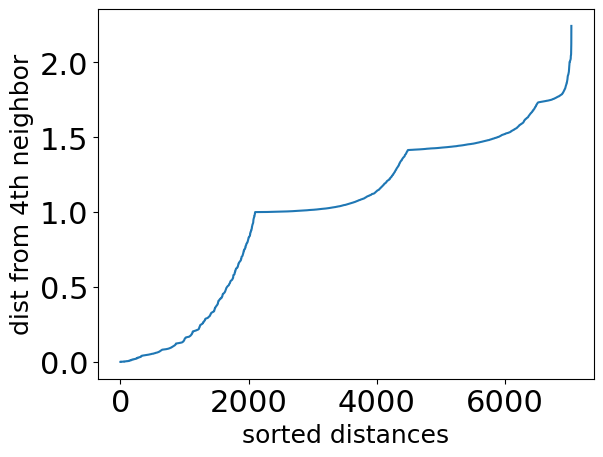

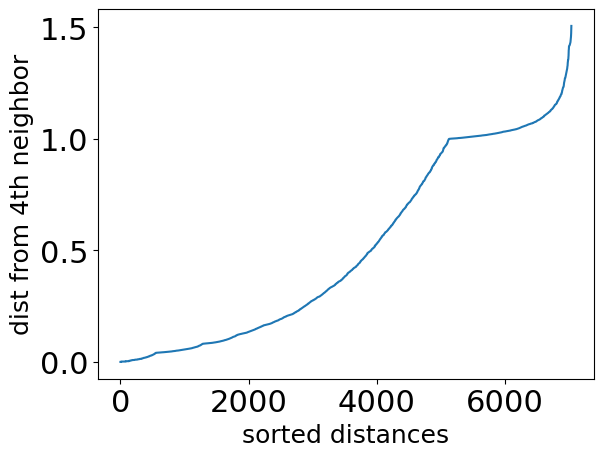

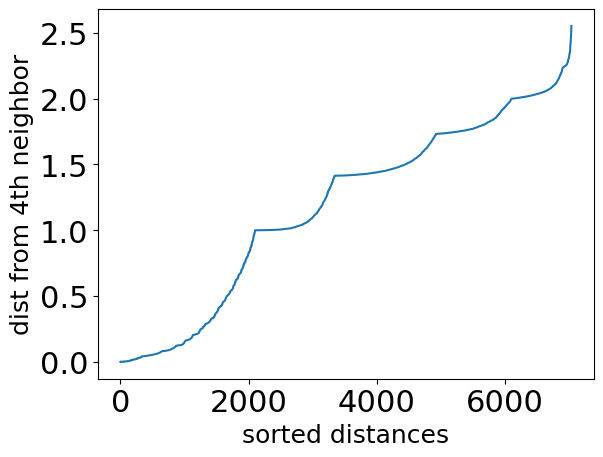

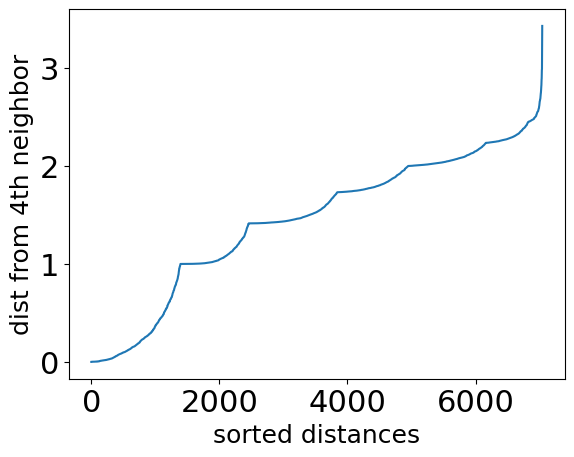

In [274]:
cluster_parameter_estimation(X,method='dbscan')
cluster_parameter_estimation(X_post,method='dbscan')
cluster_parameter_estimation(X_oh,method='dbscan')
cluster_parameter_estimation(X_oh2,method='dbscan')

The sorted distance of the kth nearest neighbor plot for DBSCAN is usually flat with an hike corresponding to a fine guess for the optimal eps. Here we can observe multiple jumps which may indicate clusters of varying density (hence, the DBSCAN clustering is likely doomed to fail). The dataframe `telco_df_post` presents the smaller number of jumps, so we can probably achieve the best performance on those data 

In [275]:
dbscan = DBSCAN(eps=1.2, min_samples=5)
dbscan.fit(X)
dbscan_post = DBSCAN(eps=1.2, min_samples=5)
dbscan_post.fit(X_post)

DBSCAN(eps=1.2)

In [276]:
print(np.unique(true_labels, return_counts=True))
print(np.unique(dbscan.labels_, return_counts=True))
print(np.unique(dbscan_post.labels_, return_counts=True))

(array([0, 1]), array([5174, 1869]))
(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([2083,  235,  574, 2198, 1521,  276,   31,    4,    9,    5,   11,
          4,    7,    9,    9,    6,    4,    5,    5,    8,    5,    7,
          4,    5,    4,    4,    5,    5]))
(array([-1,  0,  1]), array([  18, 5499, 1526]))


##### Internal evaluation

`telco_df` dataframe

In [277]:
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, dbscan.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, dbscan.labels_))

Silhouette -0.0665280419473363
Separation 1.6675220515320095


`telco_df_post` dataframe

In [278]:
print('Silhouette %s' % sklearn.metrics.silhouette_score(X, dbscan_post.labels_))
print('Separation %s' % sklearn.metrics.davies_bouldin_score(X, dbscan_post.labels_))

Silhouette 0.16176417554519174
Separation 3.4123838395992436


##### External evaluation

In [279]:
ari3 = sklearn.metrics.adjusted_rand_score(true_labels, dbscan.labels_)
hom3 = sklearn.metrics.homogeneity_score(true_labels, dbscan.labels_)
compl3 = sklearn.metrics.completeness_score(true_labels, dbscan.labels_)
vmeas3 = sklearn.metrics.v_measure_score(true_labels, dbscan.labels_, beta=2) 

ari3_post = sklearn.metrics.adjusted_rand_score(true_labels, dbscan_post.labels_)
hom3_post = sklearn.metrics.homogeneity_score(true_labels, dbscan_post.labels_)
compl3_post = sklearn.metrics.completeness_score(true_labels, dbscan_post.labels_)
vmeas3_post = sklearn.metrics.v_measure_score(true_labels, dbscan_post.labels_, beta=2) 


print(f"ARI for DBSCAN: {ari3:.4f}")
print(f"Homogeneity for DBSCAN: {hom3:.4f}")
print(f"Completeness for DBSCAN: {compl3:.4f}")
print(f"V Measure for DBSCAN: {vmeas3:.4f}")
print()
print(f"ARI for DBSCAN, post: {ari3_post:.4f}")
print(f"Homogeneity for DBSCAN, post: {hom3_post:.4f}")
print(f"Completeness for DBSCAN, post: {compl3_post:.4f}")
print(f"V Measure for DBSCAN, post: {vmeas3_post:.4f}")

ARI for DBSCAN: 0.0400
Homogeneity for DBSCAN: 0.1521
Completeness for DBSCAN: 0.0534
V Measure for DBSCAN: 0.0681

ARI for DBSCAN, post: -0.0661
Homogeneity for DBSCAN, post: 0.0552
Completeness for DBSCAN, post: 0.0591
V Measure for DBSCAN, post: 0.0577


### Supervised learning

Define the metrics we will use for model evaluation

In [280]:
metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

We will ignore warnings as they will take up a lot of screen space

In [289]:
import warnings
warnings.filterwarnings('ignore')

#### Logistic regression

{'random_state': 42}
| roc_auc: 0.8414 | accuracy: 0.7991 | precision: 0.6472 | recall: 0.5365 | f1: 0.5861 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            930            106
Actual Yes           147            226

| roc_auc: 0.8622 | accuracy: 0.8204 | precision: 0.6807 | recall: 0.6059 | f1: 0.6411 - test set



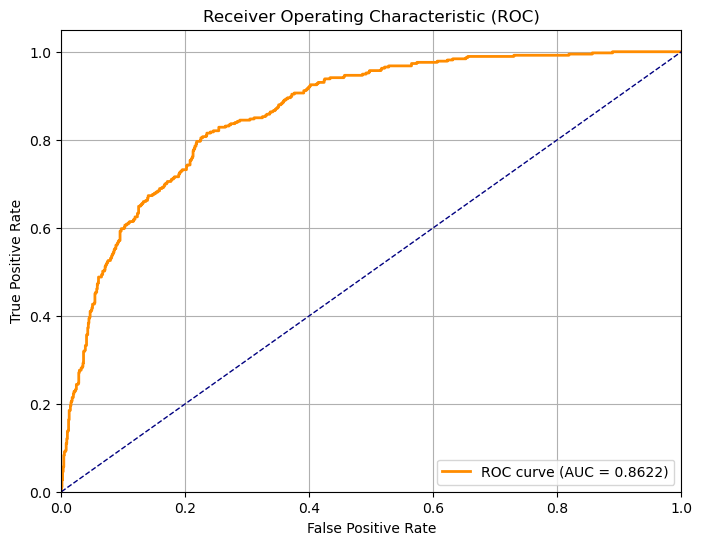

Best hyperparameters: {'C': np.float64(200.923300256505)}
{'random_state': 42}
| roc_auc: 0.8407 | accuracy: 0.7972 | precision: 0.6566 | recall: 0.4982 | f1: 0.5657 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            941             95
Actual Yes           168            205

| roc_auc: 0.8596 | accuracy: 0.8133 | precision: 0.6833 | recall: 0.5496 | f1: 0.6092 - test set



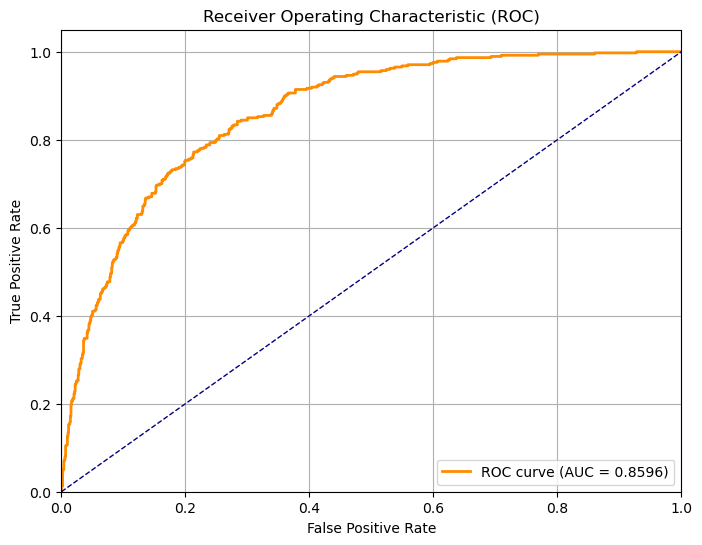

Best hyperparameters: {'C': np.float64(0.298364724028334)}
{'random_state': 42}
| roc_auc: 0.8363 | accuracy: 0.7956 | precision: 0.6374 | recall: 0.5358 | f1: 0.5817 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            923            113
Actual Yes           155            218

| roc_auc: 0.8583 | accuracy: 0.8098 | precision: 0.6586 | recall: 0.5845 | f1: 0.6193 - test set



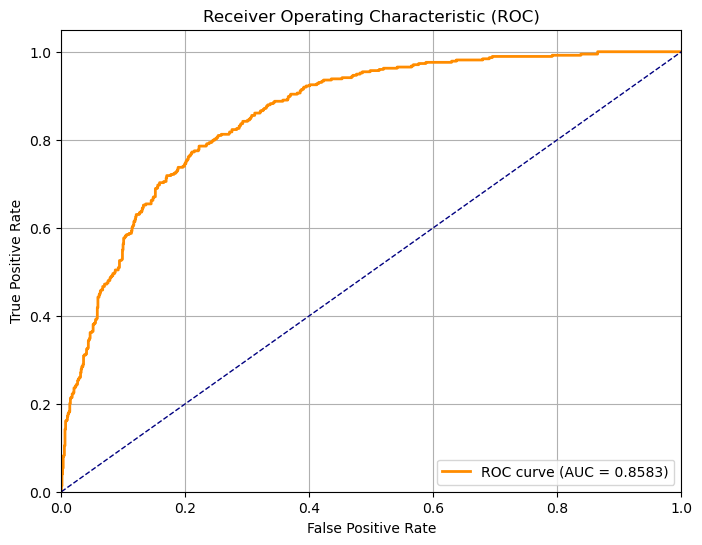

Best hyperparameters: {'C': np.float64(4.037017258596558)}


In [290]:
logistic = logistic_regression(telco_df, {'C': np.logspace(-4, 4, 100, base=10)})
logistic_oh2 = logistic_regression(telco_df_oh_tenurebin_nototal, {'C': np.logspace(-4, 4, 100, base=10)})
logistic_post = logistic_regression(telco_df_post, {'C': np.logspace(-4, 4, 100, base=10)})

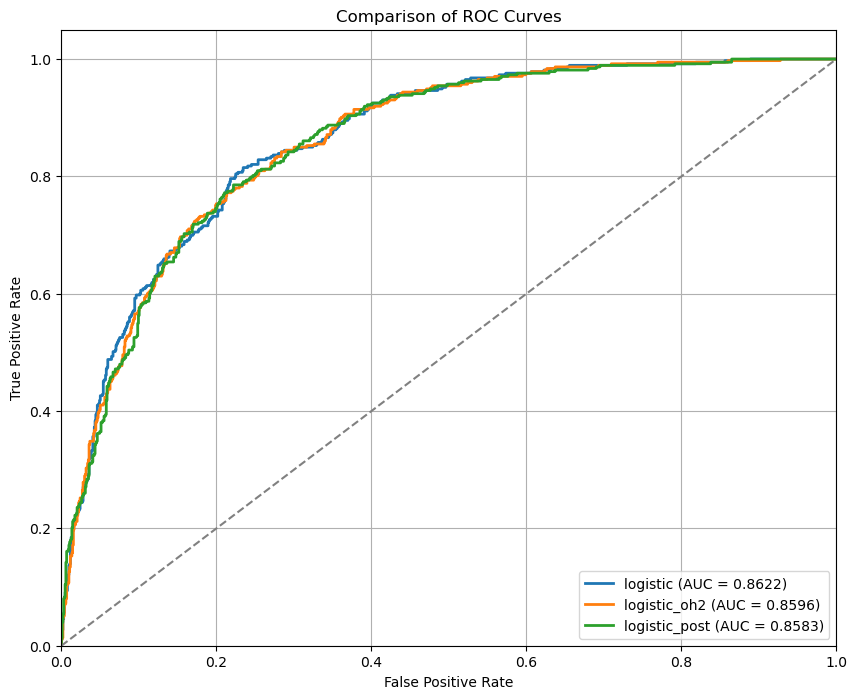

In [291]:
plot_combined_roc([logistic, logistic_oh2, logistic_post], ['logistic', 'logistic_oh2', 'logistic_post'])

We get similar performance overall, even for our lighter input dataframe

#### Support Vector Machine

Given the longer run time, here we will train the model for just 2 dataframes, `telco_df` and `telco_df_post`

{'kernel': 'rbf', 'probability': True, 'random_state': 42}
| roc_auc: 0.8286 | accuracy: 0.7903 | precision: 0.6583 | recall: 0.4369 | f1: 0.5247 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            958             78
Actual Yes           182            191

| roc_auc: 0.8529 | accuracy: 0.8155 | precision: 0.7100 | recall: 0.5121 | f1: 0.5950 - test set



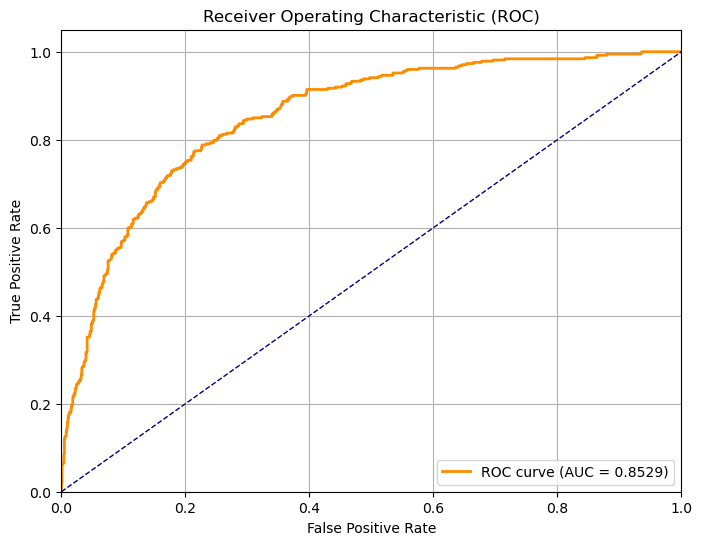

Best hyperparameters: {'C': np.float64(0.13500746736153826), 'gamma': np.float64(0.015625)}
{'kernel': 'rbf', 'probability': True, 'random_state': 42}
| roc_auc: 0.8266 | accuracy: 0.7892 | precision: 0.6521 | recall: 0.4418 | f1: 0.5261 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            947             89
Actual Yes           186            187

| roc_auc: 0.8492 | accuracy: 0.8048 | precision: 0.6775 | recall: 0.5013 | f1: 0.5763 - test set



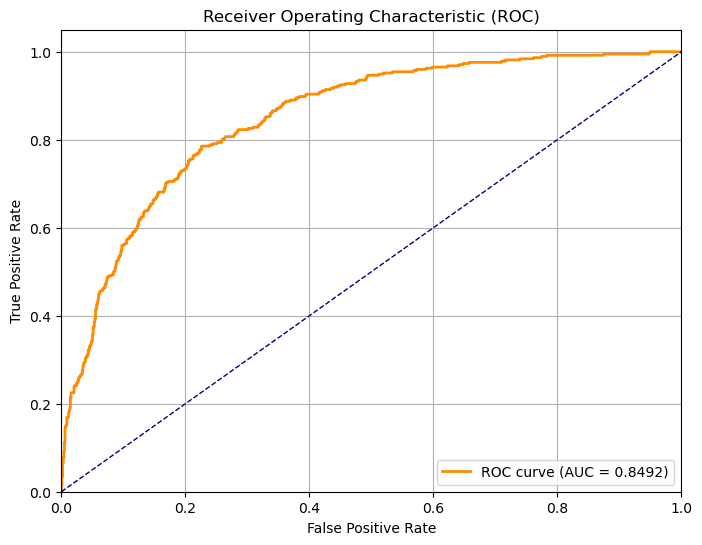

Best hyperparameters: {'C': np.float64(0.13500746736153826), 'gamma': np.float64(0.015625)}


In [292]:
grid_rbf =  {'C': np.logspace(-4, 1, 10, base=2), 'gamma': np.logspace(-6, 2, 10, base=2)}
svc = svc_rbf(telco_df, grid_rbf)
svc_post = svc_rbf(telco_df_post, grid_rbf)

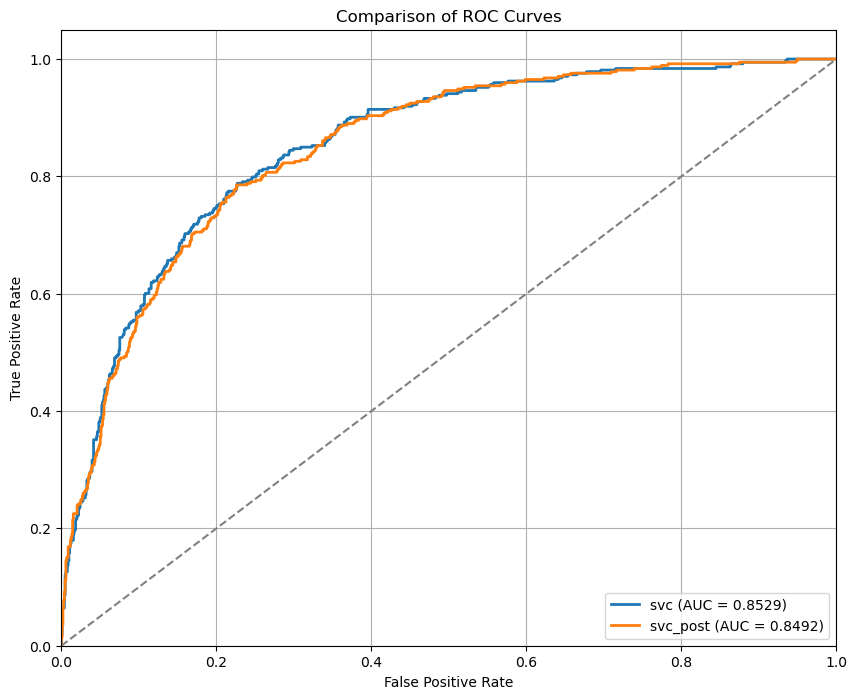

In [295]:
plot_combined_roc([svc, svc_post], ['svc', 'svc_post'])

#### Decision tree

{'random_state': 42}
| roc_auc: 0.8229 | accuracy: 0.7886 | precision: 0.6337 | recall: 0.4980 | f1: 0.5534 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            890            146
Actual Yes           137            236

| roc_auc: 0.8390 | accuracy: 0.7991 | precision: 0.6178 | recall: 0.6327 | f1: 0.6252 - test set



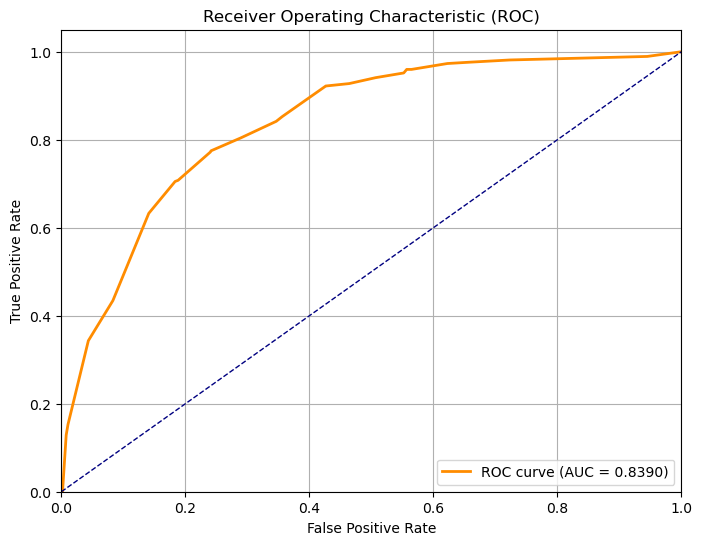

Best hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
{'random_state': 42}
| roc_auc: 0.8194 | accuracy: 0.7790 | precision: 0.5972 | recall: 0.5328 | f1: 0.5568 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            885            151
Actual Yes           138            235

| roc_auc: 0.8356 | accuracy: 0.7949 | precision: 0.6088 | recall: 0.6300 | f1: 0.6192 - test set



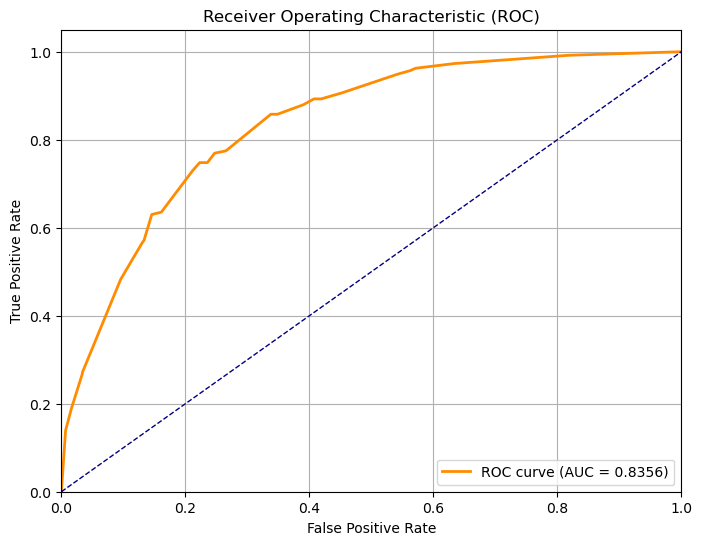

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5}
{'random_state': 42}
| roc_auc: 0.8228 | accuracy: 0.7874 | precision: 0.6319 | recall: 0.4951 | f1: 0.5508 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            888            148
Actual Yes           138            235

| roc_auc: 0.8386 | accuracy: 0.7970 | precision: 0.6136 | recall: 0.6300 | f1: 0.6217 - test set



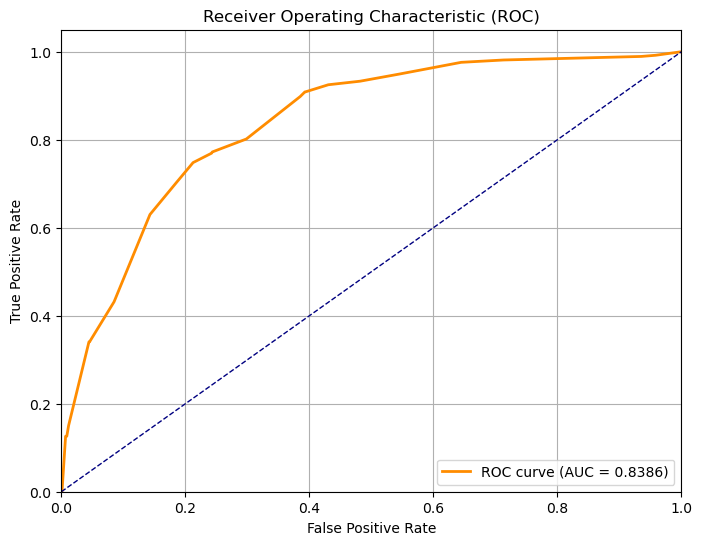

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [301]:
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}
dt = decision_tree(telco_df, param_grid)
dt_oh2 = decision_tree(telco_df_oh_tenurebin_nototal, param_grid)
dt_post = decision_tree(telco_df_post, param_grid)

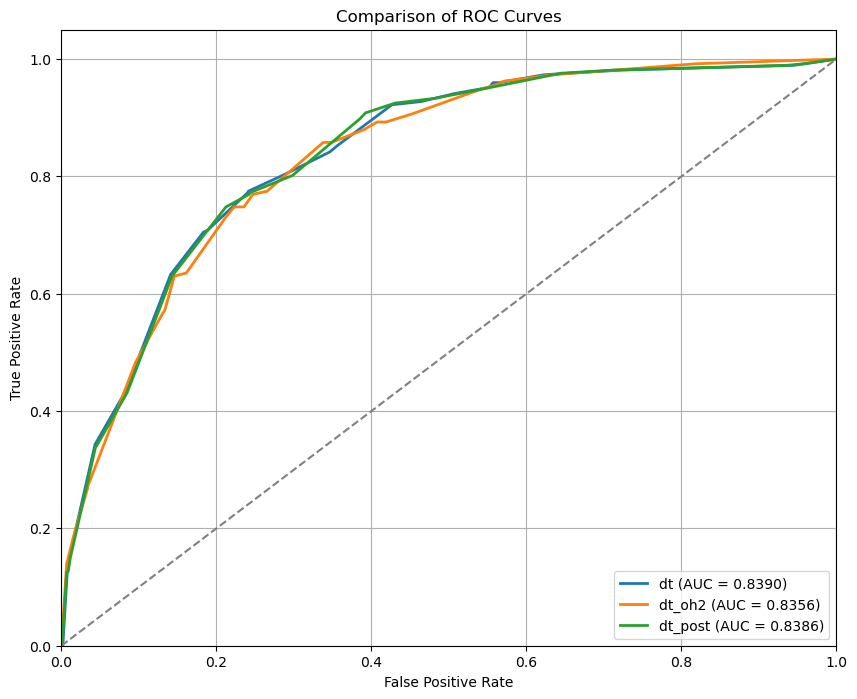

In [302]:
plot_combined_roc([dt, dt_oh2, dt_post], ['dt', 'dt_oh2', 'dt_post'])

#### Random forest

{'random_state': 42}
| roc_auc: 0.8398 | accuracy: 0.7984 | precision: 0.6590 | recall: 0.4996 | f1: 0.5681 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            942             94
Actual Yes           175            198

| roc_auc: 0.8581 | accuracy: 0.8091 | precision: 0.6781 | recall: 0.5308 | f1: 0.5955 - test set



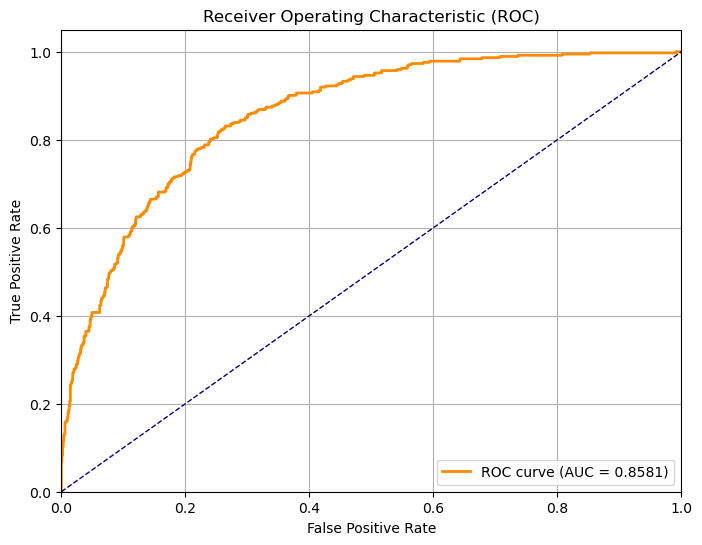

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
{'random_state': 42}
| roc_auc: 0.8343 | accuracy: 0.7971 | precision: 0.6559 | recall: 0.4964 | f1: 0.5649 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            947             89
Actual Yes           174            199

| roc_auc: 0.8586 | accuracy: 0.8133 | precision: 0.6910 | recall: 0.5335 | f1: 0.6021 - test set



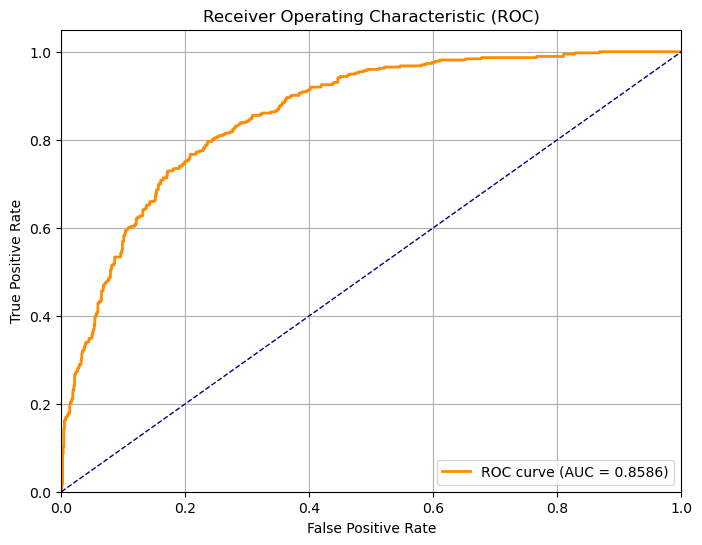

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
{'random_state': 42}
| roc_auc: 0.8356 | accuracy: 0.7912 | precision: 0.6362 | recall: 0.4996 | f1: 0.5593 - cross-validation

Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            937             99
Actual Yes           172            201

| roc_auc: 0.8589 | accuracy: 0.8077 | precision: 0.6700 | recall: 0.5389 | f1: 0.5973 - test set



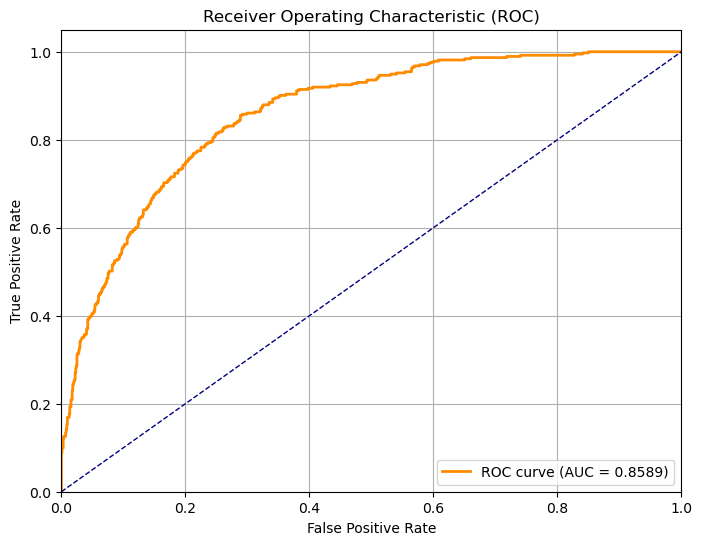

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [304]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
rf = random_forest(telco_df, param_grid)
rf_oh2 = random_forest(telco_df_oh_tenurebin_nototal, param_grid)
rf_post = random_forest(telco_df_post, param_grid)

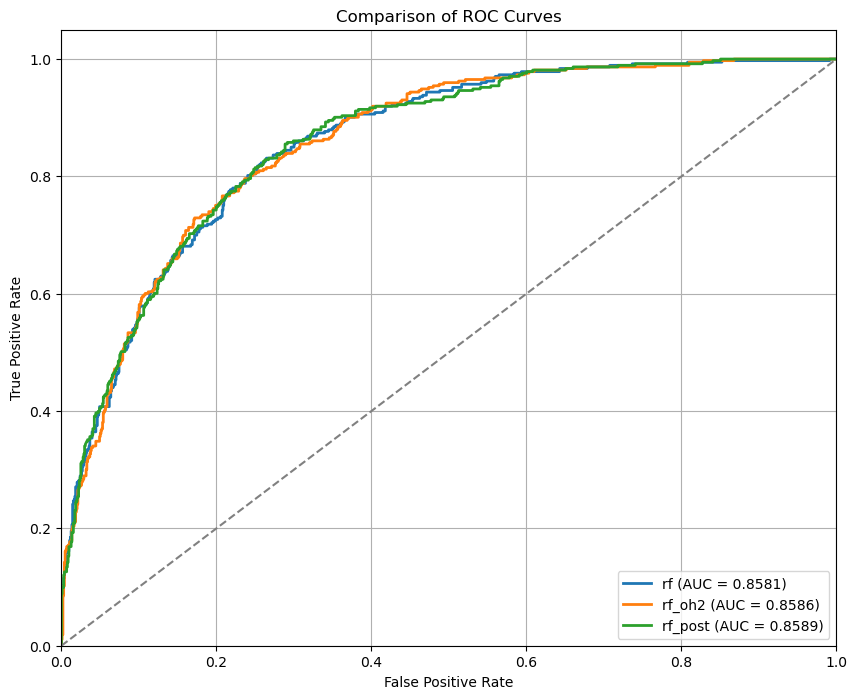

In [305]:
plot_combined_roc([rf, rf_oh2, rf_post], ['rf', 'rf_oh2', 'rf_post'])

#### Compare different models' ROC's

Given that the ROC's for a given model trained on different dataframes to not differ all that much, we can choose just one instance to compare different models

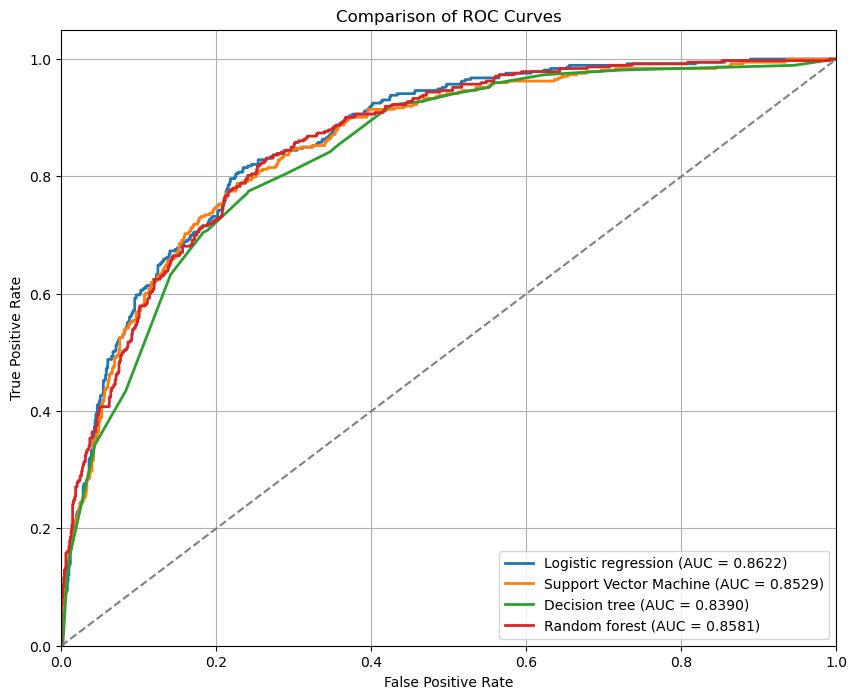

In [306]:
plot_combined_roc([logistic, svc, dt, rf], ['Logistic regression', 'Support Vector Machine', 'Decision tree', 'Random forest'])

### Association rules

In [ ]:
telco_df_ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Partner                                  7043 non-null   int64
 1   Dependents                               7043 non-null   int64
 2   PhoneService                             7043 non-null   int64
 3   PaperlessBilling                         7043 non-null   int64
 4   MultipleLines_No                         7043 non-null   bool 
 5   MultipleLines_No phone service           7043 non-null   bool 
 6   MultipleLines_Yes                        7043 non-null   bool 
 7   InternetService_DSL                      7043 non-null   bool 
 8   InternetService_Fiber optic              7043 non-null   bool 
 9   InternetService_No                       7043 non-null   bool 
 10  OnlineSecurity_No                        7043 non-null   bool 
 11  Onli

In [27]:
telco_df_ar = pd.get_dummies(telco_df_ar, columns=['Churn'])

The following used ~4GB of RAM

In [31]:
frequent_itemsets = apriori(telco_df_ar, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [32]:
churn_rules = rules[rules['consequents'].apply(lambda x: 'Churn_1' in x)]
churn_rules.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
17486,"(OnlineSecurity_No, tenure_bin_Low)","(Contract_Month-to-month, Churn_1)",0.171944,0.234985,0.107767,0.626755,2.667211,1.0,0.067362,2.049631,0.754872,0.360228,0.512107,0.542683
19999,"(TechSupport_No, tenure_bin_Low)","(Contract_Month-to-month, Churn_1)",0.171660,0.234985,0.106489,0.620347,2.639944,1.0,0.066151,2.015039,0.749938,0.354778,0.503732,0.536760
105840,"(PaymentMethod_Electronic check, Contract_Mont...","(Churn_1, PhoneService)",0.160159,0.241232,0.101661,0.634752,2.631287,1.0,0.063026,2.077402,0.738185,0.339176,0.518630,0.528088
106319,"(PaymentMethod_Electronic check, Contract_Mont...","(Churn_1, PhoneService)",0.161579,0.241232,0.101661,0.629174,2.608165,1.0,0.062683,2.046155,0.735416,0.337577,0.511279,0.525299
105347,"(OnlineBackup_No, Contract_Month-to-month, Onl...","(Churn_1, PhoneService)",0.174500,0.241232,0.106489,0.610252,2.529727,1.0,0.064394,1.946817,0.732526,0.344353,0.486341,0.525844
106000,"(OnlineBackup_No, Contract_Month-to-month, Tec...","(Churn_1, PhoneService)",0.175777,0.241232,0.107199,0.609855,2.528079,1.0,0.064795,1.944833,0.733349,0.346013,0.485817,0.527117
105691,"(TechSupport_No, Contract_Month-to-month, Onli...","(Churn_1, PhoneService)",0.216385,0.241232,0.131336,0.606955,2.516060,1.0,0.079137,1.930487,0.768941,0.402524,0.481996,0.575697
105556,"(Contract_Month-to-month, DeviceProtection_No,...","(Churn_1, PhoneService)",0.172796,0.241232,0.104359,0.603944,2.503578,1.0,0.062675,1.915809,0.726026,0.337001,0.478027,0.518276
34590,"(PaymentMethod_Electronic check, Contract_Mont...","(Churn_1, PhoneService)",0.185574,0.241232,0.112026,0.603673,2.502452,1.0,0.067260,1.914497,0.737197,0.355886,0.477669,0.534032
57705,"(PaymentMethod_Electronic check, Contract_Mont...",(Churn_1),0.160159,0.265370,0.101661,0.634752,2.391951,1.0,0.059160,2.011317,0.692906,0.313897,0.502813,0.508922


In [33]:
# First, convert frozen sets to readable strings
churn_rules['antecedents_str'] = churn_rules['antecedents'].apply(lambda x: ', '.join(sorted(x)))
churn_rules['consequents_str'] = churn_rules['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Then, create a 'rule' column
churn_rules['rule'] = churn_rules.apply(lambda row: f"{row['antecedents_str']} => {row['consequents_str']}", axis=1)

# Select and format relevant columns
top_rules = churn_rules[['rule', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)

# Display with better formatting
print(top_rules.to_string(index=False))

                                                                                                                            rule  support  confidence     lift
                                                           OnlineSecurity_No, tenure_bin_Low => Churn_1, Contract_Month-to-month 0.107767    0.626755 2.667211
                                                              TechSupport_No, tenure_bin_Low => Churn_1, Contract_Month-to-month 0.106489    0.620347 2.639944
Contract_Month-to-month, InternetService_Fiber optic, OnlineSecurity_No, PaymentMethod_Electronic check => Churn_1, PhoneService 0.101661    0.634752 2.631287
   Contract_Month-to-month, InternetService_Fiber optic, PaymentMethod_Electronic check, TechSupport_No => Churn_1, PhoneService 0.101661    0.629174 2.608165
               Contract_Month-to-month, InternetService_Fiber optic, OnlineBackup_No, OnlineSecurity_No => Churn_1, PhoneService 0.106489    0.610252 2.529727
                  Contract_Month-to-month, Int

/tmp/ipykernel_128250/188360049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rules['antecedents_str'] = churn_rules['antecedents'].apply(lambda x: ', '.join(sorted(x)))
/tmp/ipykernel_128250/188360049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rules['consequents_str'] = churn_rules['consequents'].apply(lambda x: ', '.join(sorted(x)))
/tmp/ipykernel_128250/188360049.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row